In [1]:
#//*** GEOPANDAS sources
#https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
#https://geopandas.org/docs/user_guide/mapping.html

#//*** Build Custom Color Gradients
#https://coolors.co/gradient-palette/ffffff-e0472b?number=9

#//*** pandas_bokeh
#//*** https://pythonawesome.com/bokeh-plotting-backend-for-pandas-and-geopandas/

#//*** Clean geopandas install
#//***conda create -n geopandas -c conda-forge python=3.8 geopandas

Hospitalization research:
Data.gov search for tag: hhs-covid-19

posible lead: https://healthdata.gov/dataset/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/4cnb-m4rz

possible lead individual facility breakdown by week May - October 2021: https://healthdata.gov/dataset/COVID-19-Hospital-Data-Coverage-Report-v4wn-auj8-A/ewep-8fwa

This look like State Level Data: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

Data CSV Link: https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

Healthdata.gov Hospitalization Search: https://healthdata.gov/browse?q=hospitalization&sortBy=relevance

Hospital Facility TimeSeries: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u


Other Sources:
 - COVID-19 State and County Policy Orders (infographic?): https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders-9408a

- [Graph: Infographic Visualization](#infographic_visualization)

<a id="top"></a> 
## Internal Links ##

- Working [working](#working).

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

- [Load/Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths: rebuild state_daily_df](#rebuild_state_daily_df)

- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)

- [ Load or Rebuild County Level Vaccine Data Set: county_vax_df](#rebuild_county_vax_df)

- [ USA Vaccines ](#build_USA_Vaccines)

- [ Build Vaccine Tiers: County Data: county_tier_df](#build_tiers_county)

- [Build Vaccine Tiers: Statewide Data](#build_tiers_statewide)

- [ Build: hospital_df ](#build_hospital_df)

- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

## Analyze ##
- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)

## Graphs ##
- [ Blog Graphs ](#build_blog_graphs)

## HTML Processing ##


### CDC Community Transmission Guidelines

https://covid.cdc.gov/covid-data-tracker/#county-view



![](transmission_risk.png)

<a id="working"></a> 
# Working #

In [2]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random
from PIL import Image

import shutil
import json

import geopandas as gpd

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

import pandas_bokeh
pandas_bokeh.output_notebook()

#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
#https://docs.bokeh.org/en/latest/docs/user_guide/embed.html

#//*** Bokeh Categorical Labels
#https://docs.bokeh.org/en/0.12.10/docs/user_guide/categorical.html

#//*** Color Palettes: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
#//*** Hover Tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
from datetime import datetime
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

#//*** Holds 
out_plot = {}
out_stats = {}
out_images = []
out_exec_summary_images = []

med_figsize_x =634
med_figsize_y = 512

#df_list = []

#from sklearn import linear_model
#from math import sqrt
#from sklearn.metrics import mean_squared_error



Loading BokehJS ...

In [3]:
#"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

#Hospitalizations - State
#https://www.cdc.gov/nhsn/covid19/report-patient-impact.html#anchor_1594393649
#DL: https://www.cdc.gov/nhsn/pdfs/covid19/covid19-NatEst.csv

# File Control #
 * use_cached_files = True - Use the Locally cached versions of the data
 * use_cached_files = False - Download updated source Data
 
 * rebuild_master_files = True - Rebuild county_daily_df. Takes 5-10 minutes
 * rebuild_master_files = False - Uses the cached version of the files

In [4]:
#//************************************************************************
#//*** If True, will rely on locally stored files
#//*** If False, will Download current data and rebuild all data sets
#//*** Should only be set to False if Data needs to be updated
#//************************************************************************
#use_cached_files = True
#rebuild_master_files = False

out_controls = {}
manage_df = {}

# Filepaths #

In [5]:
#//*** Raw Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename = "z_us_death_cases.csv"
vaccine_data_filename = "z_us_vaccination.csv"
county_vaccine_data_filename = "z_us_county_vaccination.csv.zip"
state_hospital_filename = "z_state_hospital.csv"

#//*** Filenames for Caching files locally
attrib_confirm_filename = "attrib_confirm_df.dat.zip"
attrib_death_filename =  "attrib_death_df.dat.zip"
all_dates_filename = "all_dates.json"
geo_vax_filename = "geo_vax_df.dat"
casevax_filename = "casevax.dat.zip"
county_daily_df_filename = "z_county_daily_df.csv.zip"
state_daily_df_filename = "z_state_daily_df.csv.zip"
hospital_df_filename = "z_hospital_df.csv.zip"

county_tier_df_filename = "z_county_tier_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"

In [6]:
county_daily_df = pd.read_pickle(county_daily_df_filename)


<a id="rebuild_county_daily_df"></a> 
# Load or Rebuild County Level Combined Data Set: Cases & Deaths #

<a id="rebuild_county_vax_df"></a> 
# Load or Rebuild County Level Vaccine Data Set: county_vax_df #

In [7]:
#print("Loading Raw Vaccine Data")
#//*** read Raw Vaccine csv
county_vax_df = pd.read_pickle(county_vaccine_data_filename)

manage_df["county_vax_df"] = "County Vaccination Data [ 2020-12-13 - Present ]"

#//*** Filter Columns to get just the Completed Values
cols = ['Date','FIPS','Recip_County','Recip_State','Series_Complete_Pop_Pct','Series_Complete_Yes','Administered_Dose1_Pop_Pct','Administered_Dose1_Recip']


#//*** remove States not in continental US
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AK" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "HI" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AS" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "GU" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "MP" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "PR" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "VI" ]
county_vax_df = county_vax_df[county_vax_df["FIPS"] != "UNK" ]
county_vax_df['FIPS'] = county_vax_df['FIPS'].astype(int)
county_vax_df['Date'] = county_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())

county_vax_df = county_vax_df[cols]

#//*** Cleanup Column Names
ren_cols = {
'Administered_Dose1_Recip' : 'first_dose_count',
'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
'Series_Complete_Yes' : 'total_vaccinated_count',
'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
}

cols = list(county_vax_df.columns)

for find,replace in ren_cols.items():
    cols = [replace if i==find else i for i in cols]

county_vax_df.columns=cols
    
county_vax_df

Date   FIPS     Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
0        2021-11-16  37173     Swain County          NC                      49.8                    7108            62.2            8877.0
2        2021-11-16  28029    Copiah County          MS                      48.9                   13727            55.3           15512.0
3        2021-11-16  38053  McKenzie County          ND                      19.4                    2913            24.8            3723.0
4        2021-11-16  26121  Muskegon County          MI                      50.6                   87784            52.5           91121.0
5        2021-11-16  17167  Sangamon County          IL                      59.8                  116506            64.5          125524.0
...             ...    ...              ...         ...                       ...                     ...             ...               ...
1115906  2020-12-13  18099  Marshall County          IN                       0.0                       0             0.0               0.0
1115907  2020-12-13  21185    Oldham County          KY                       0.0                       0             0.0               0.0
1115908  2020-12-13  55135   Waupaca County          WI                       0.0                       0             0.0               0.0
1115909  2020-12-13  40145   Wagoner County          OK                       0.0                       0             0.0               0.0
1115910  2020-12-13   5011   Bradley County          AR                       0.0                       0             0.0               0.0

[1056927 rows x 8 columns]

<a id="rebuild_state_daily_df"></a> 
# Load or Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths #

In [8]:
state_daily_df = pd.read_pickle(state_daily_df_filename)
state_daily_df

manage_df['state_daily_df'] = "State Population Vaccination Case Death [2020-12-14 - Present]"

# Read all dates JSON
with open(all_dates_filename, "r") as infile:
    all_dates = json.loads(infile.read())['all_dates']

- [ go to Top](#top)
- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)
<a id="build_state_case_death_df"></a> 
# Build State Level: state_case_death_df - cases & deaths only #




In [9]:
#//**************************************************************************************************
#//**** Build Just Cases and Deaths at State Level. These will integrate with Hospitalizations
#//**** Orginally geo_vax_df...Now: state_daily_df
#//**************************************************************************************************

manage_df['confirm_df'] = "Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]"
manage_df['death_df'] = "Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]"
#//**** Load Confirmed Data
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df.dropna(subset=["FIPS"])

#//**** Load death Data
death_df = pd.read_csv(death_data_filename)
death_df = death_df[death_df["Admin2"] != "Unassigned"]
death_df = death_df.dropna(subset=["FIPS"])

#//**** Load raw Vax Data
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)


#//***************************************
#//*** Build Vaccine Geographic Data
#//***************************************

#//*** Get Shape File
state_case_death_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

#//*** Keep the important Columns
state_case_death_df = state_case_death_df[['STATEFP','GEOID','NAME','geometry']]

state_case_death_df['GEOID'] = state_case_death_df['GEOID'].astype(int)
state_case_death_df['STATEFP'] = state_case_death_df['STATEFP'].astype(int)



#//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
#//*** Load DF with States and FIPS values
#state_fips = pd.read_csv("state_fips.csv")
#geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

#//*** remove States not in continental US
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Alaska" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Hawaii" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Puerto Rico" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "District of Columbia" ]

#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "HI" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "AS" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "GU" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "MP" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "PR" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "VI" ]



#geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

state_case_death_df = state_case_death_df.sort_values('NAME').reset_index()

#//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data

#//***Process Deaths
us_deaths_df = pd.DataFrame()

for group in death_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[12:]]
    #print(loop_stats_df.columns)

    base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

    base_row = pd.DataFrame(base_row).transpose()
    stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['state','Date','tot_death']
    stats_df['state'] = stats_df['state'].fillna(group[0])
    base_row = base_row.merge(stats_df,left_on="state",right_on="state")
    us_deaths_df = pd.concat([us_deaths_df,base_row])

#print(us_deaths_df)

us_df = pd.DataFrame()
#//***Process confirmed and merge with deaths
for group in confirm_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[11:]]
    #print(loop_stats_df.columns)
    stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['Date','tot_confirm']

    us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])


us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))  
us_df = us_df.reset_index(drop='True')

for col in ['New_Cases','New_Deaths']:
    us_df[col] = np.nan



#//*** Drops Diamon Princess, Virgin Islands, and anything not listed as a state in the continental united states
state_case_death_df = state_case_death_df.merge(us_df, left_on='NAME', right_on='state')
tdf = pd.DataFrame()

for group in state_case_death_df.groupby('state'):
    loop_df = group[1].copy()
    
    
    
    loop_df['New_Cases'] = loop_df['tot_confirm'].copy().diff(2)

    #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0

    loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
    loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
    loop_df['New_Deaths'] = loop_df['tot_death'].copy().diff(2)

            #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
    loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
    loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
    
    loop_df = loop_df.dropna()
    
    loop_df['loc'] = (state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0]
    
    #print((state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0])
    #print(loop_df)
    tdf = pd.concat([tdf,loop_df])
state_case_death_df = tdf
del tdf
del us_df
del us_deaths_df

state_case_death_df = state_case_death_df.sort_values(['Date','NAME'])
state_case_death_df

manage_df['state_case_death'] = "State Level Cases and Deaths Only [2020/01/30 - Present]"
#print(state_case_death_df)

<a id="rebuild_column_data_for_bokeh"></a> 
# Load or Rebuild Columwise Dataframes for Bokeh Slider Plots: attrib_confirm_df, attrib_death_df #

In [10]:
attrib_confirm_df = pd.read_pickle(attrib_confirm_filename)
manage_df['attrib_confirm_df'] = "Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]"
attrib_death_df = pd.read_pickle(attrib_death_filename)
manage_df['attrib_death_df'] = "Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]"
#print("Loading Cached: death_df")

- [ go to Top](#top)
- [ Build: hospital_df](#build_hospital_df)
<a id="build_hospital_df"></a> 
# Build: hospital_df #


In [11]:
#//*** Raw data description
#https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
#//*** There are 116 Columns. Gotta Pair it down
manage_df['hospital_df'] = "Statewide Hospitalization Numbers [2020-01-01 - Present]"
hospital_df = pd.read_csv(state_hospital_filename)
hospital_df

#//*** Remove columns that include these words
exclude_cols = ['coverage','numerator','denominator','previous','influenza','geocoded_state','total_pediatric_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_not_reported','anticipated','staffed_icu_adult_patients_confirmed_covid','total_adult_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_no','deaths_covid']

cols = []

for col in hospital_df.columns:
    for frag in exclude_cols:
        if frag in col:
            del hospital_df[col]
            break
            
            
#//*** rename columns for redability            
ren_cols = {
    'critical_staffing_shortage_today_yes' : "short_staffed",
    'hospital_onset_covid' : 'got_covid_at_hosp',
    'inpatient_beds' : 'total_beds',
    'inpatient_beds_used' : "beds_used",
    'inpatient_beds_used_covid' : 'covid_beds_used',
    'staffed_adult_icu_bed_occupancy' : "icu_occupancy",
    'staffed_icu_adult_patients_confirmed_and_suspected_covid' : 'covid_icu',
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_adult',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_kids',
    'total_staffed_adult_icu_beds' : 'icu_total',
    'inpatient_beds_utilization' : 'beds_used_pct',
    'percent_of_inpatients_with_covid' : 'covid_patients_pct',
    'inpatient_bed_covid_utilization' : 'covid_beds_pct',
    'adult_icu_bed_covid_utilization' : 'icu_used',
    'adult_icu_bed_utilization' : 'icu_used_pct',
    'on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses' : 'therapy_a',
    'on_hand_supply_therapeutic_b_bamlanivimab_courses' : 'therapy_b',
    'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses' : 'therapy_b',
    'date' : 'Date',
}

#//*** Rename Columns for readability
cols = hospital_df.columns
for find_col,replace_col in ren_cols.items():
    if find_col in cols:
        cols = np.where(cols == find_col,replace_col,cols)

hospital_df.columns = cols

#//*** Convert everything to floats where possible
for col in hospital_df.columns:
    try:
        hospital_df[col] = hospital_df[col].astype(float)
    except:
        continue
        
hospital_df['Date'] = hospital_df['Date'].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").date())
        
hospital_df = hospital_df.sort_values('Date')

hospital_df

state        Date  short_staffed  got_covid_at_hosp  total_beds  beds_used  covid_beds_used  icu_occupancy  covid_icu  covid_beds_adult  covid_beds_kids  icu_total  beds_used_pct  \
27969    MN  2020-01-01            0.0                0.0        46.0        NaN              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
31403    NC  2020-01-01            0.0                0.0        72.0        NaN              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
30525    LA  2020-01-01            0.0                NaN         NaN        NaN              NaN            NaN        NaN               NaN              NaN        NaN            NaN   
32990    IN  2020-01-01            0.0                0.0        30.0       15.0              0.0            NaN        NaN               NaN              NaN        NaN       0.500000   
25932    MT  2020-01-01            0.0                0.0        36.0       12.0              0.0            NaN        NaN               NaN              NaN        NaN       0.333333   
...     ...         ...            ...                ...         ...        ...              ...            ...        ...               ...              ...        ...            ...   
23209    AL  2021-11-17           31.0                7.0     15101.0    11715.0            387.0         1382.0      118.0             375.0             12.0     1591.0       0.775776   
17655    MS  2021-11-17            9.0                1.0      7876.0     5104.0            229.0          632.0       59.0             211.0             18.0      766.0       0.648045   
22647    NM  2021-11-17           26.0                1.0      4223.0     3300.0            638.0          399.0      174.0             624.0             14.0      439.0       0.781435   
12812    TN  2021-11-17           24.0                6.0     18525.0    13296.0            811.0         1686.0      235.0             799.0             12.0     2430.0       0.717733   
22066    HI  2021-11-17            3.0                1.0      2513.0     1884.0             63.0          143.0        9.0              60.0              3.0      210.0       0.749702   

       covid_patients_pct  covid_beds_pct  icu_used  icu_used_pct  therapy_a  therapy_b  therapy_b  
27969                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
31403                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
30525                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
32990            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
25932            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
...                   ...             ...       ...           ...        ...        ...        ...  
23209            0.034184        0.026476  0.075982      0.868636     5518.0     1810.0     1883.0  
17655            0.045293        0.029318  0.079088      0.825065     7236.0      841.0     1104.0  
22647            0.197218        0.154967  0.416268      0.908884      263.0      155.0      144.0  
12812            0.062251        0.044551  0.100642      0.693827      277.0        4.0      127.0  
22066            0.033439        0.025070  0.042857      0.680952      470.0        0.0        2.0  

[33545 rows x 20 columns]

<a id="build_tiers_statewide"></a> 
# Build Vaccine Tiers: Statewide Data #

In [12]:
#//*** Build State Tiers By Vaccinated Percent

plot_df = state_daily_df

print()
plot_df = plot_df[plot_df['Date'] > plot_df['Date'].unique()[0]]
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].min())
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].max())


#//*** Build Sorted list of States by Vaccination
#cats = list(plot_df[plot_df['Date'] == plot_df['Date'].min()].sort_values('death_7_day_avg',ascending=False)['state'])
#cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
#category_col = 'Name'
vax_range_dict = {}
vax_range_dict['40'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] < 45) ]['Name'])
vax_range_dict['45'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 45) & (plot_df['total_vaccinated_percent'] < 50)]['Name'])
vax_range_dict['50'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 50) & (plot_df['total_vaccinated_percent'] < 55)]['Name'])
vax_range_dict['55'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 55) & (plot_df['total_vaccinated_percent'] < 60)]['Name'])
vax_range_dict['60'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 60) & (plot_df['total_vaccinated_percent'] < 65)]['Name'])
vax_range_dict['65'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 65) ]['Name'])


vax_tier_state_df = pd.DataFrame()

cols = ['Date','tier','population','total_vaccinated_count','first_dose_count','tot_confirm','tot_death','New_Cases','New_Deaths']





for index in ['40','45','50','55','60','65']:

    tier_df = pd.DataFrame()

    #//*** Get DF that contains list of States. Loop through those tiers and combine them
    for group in plot_df[plot_df['Name'].str.contains('|'.join(vax_range_dict[index]))].groupby('Date'):

        loop_list = [group[0],f'total_{index}']
        for col in cols[2:]:
            loop_list.append(group[1][col].astype(int).sum())

        loop_df = pd.DataFrame(loop_list).transpose()
        loop_df.columns = cols

        for col in cols[2:]:
            loop_df[col] = loop_df[col].astype(int)
            
        tier_df = pd.concat([tier_df, loop_df])
        #print(loop_df)

    tier_df['case_7_day_avg'] = tier_df['New_Cases'].rolling(14).mean()
    tier_df['death_7_day_avg'] = tier_df['New_Deaths'].rolling(14).mean()

    tier_df['case_avg_100k'] = tier_df['case_7_day_avg'] / (tier_df['population'] / 100000) 
    tier_df['death_avg_100k'] = tier_df['death_7_day_avg'] / (tier_df['population'] / 100000) 
    
    tier_df['total_vaccinated_percent'] = tier_df['total_vaccinated_count'] / tier_df['population']
    tier_df['first_dose_pct'] = tier_df['first_dose_count'] / tier_df['population']
    
    vax_tier_state_df = pd.concat([vax_tier_state_df,tier_df])

vax_tier_state_df.dropna(inplace=True)
vax_tier_state_df = vax_tier_state_df.reset_index()
#print(vax_tier_state_df)

#//*** Build Sorted list of States by Vaccination
cats = list(vax_tier_state_df['tier'].unique())
cats
manage_df['vax_tier_state_df'] = "State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]"
vax_tier_state_df[vax_tier_state_df['tier'] == 'total_40'].reset_index()


41.5
72.2


level_0  index       Date      tier  population  total_vaccinated_count  first_dose_count  tot_confirm  tot_death  New_Cases  New_Deaths  case_7_day_avg  death_7_day_avg  case_avg_100k  \
0          0      0 2020-12-28  total_40     3579212                       0                 0       218446       2640       2482          33     4597.428571        66.642857     128.448065   
1          1      0 2020-12-29  total_40     3579212                       0                 0       221297       2677       4372          69     4528.928571        65.642857     126.534236   
2          2      0 2020-12-30  total_40     3579212                       0                 0       224089       2721       5643          81     4525.571429        64.428571     126.440441   
3          3      0 2020-12-31  total_40     3579212                       0                 0       226411       2774       5114          97     4488.285714        63.928571     125.398711   
4          4      0 2021-01-01  total_40     3579212                       0                 0       228897       2797       4808          76     4426.857143        62.500000     123.682451   
..       ...    ...        ...       ...         ...                     ...               ...          ...        ...        ...         ...             ...              ...            ...   
319      319      0 2021-11-12  total_40     3579212                 1532389           1773249       581441       8345       3113          50     2790.571429        55.714286      77.966084   
320      320      0 2021-11-13  total_40     3579212                 1533439           1774683       582254       8355       2893          42     2765.428571        55.428571      77.263615   
321      321      0 2021-11-14  total_40     3579212                 1534911           1776316       582924       8355       1483          10     2729.071429        55.857143      76.247829   
322      322      0 2021-11-15  total_40     3579212                 1535541           1777297       584088       8388       1834          33     2701.214286        54.142857      75.469525   
323      323      0 2021-11-16  total_40     3579212                 1541157           1855113       585356       8461       2432         106     2656.928571        55.428571      74.232221   

     death_avg_100k  total_vaccinated_percent  first_dose_pct  
0          1.861942                  0.000000        0.000000  
1          1.834003                  0.000000        0.000000  
2          1.800077                  0.000000        0.000000  
3          1.786107                  0.000000        0.000000  
4          1.746194                  0.000000        0.000000  
..              ...                       ...             ...  
319        1.556608                  0.428136        0.495430  
320        1.548625                  0.428429        0.495831  
321        1.560599                  0.428840        0.496287  
322        1.512703                  0.429016        0.496561  
323        1.548625                  0.430586        0.518302  

[324 rows x 17 columns]

- [ go to Top](#top)
- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

<a id="state_hosp_tiers_df"></a> 
# Build: state_hosp_tiers_df #

In [13]:
working_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()]



hosp_tier_dict = {}
#//*** Group FIPS by Total vaccinated Percent
#//*** Put Results in Dictionary
for i in range(20):
    low_i = i * 5
    high_i = low_i+5
    loop_df = working_df[ (working_df['total_vaccinated_percent'] >= low_i) & (working_df['total_vaccinated_percent'] < high_i) ]
    if len(loop_df) > 0:
        
        hosp_tier_dict[low_i] = {'FIPS' : list(loop_df['FIPS'].astype(int).unique()), 'state' : list(loop_df['Postal Code'].unique())}
print(hosp_tier_dict)


state_hosp_tiers_df = pd.DataFrame()

hosp_cols = ['total_beds','beds_used','covid_beds_used','icu_total','icu_used','covid_icu','covid_beds_adult','covid_beds_kids']

sum_cols_state = ['population','tot_confirm','tot_death']

working_df = state_case_death_df

#//*** Get DF that contains list of States. Loop through those tiers and combine them
for tier,loop_dict in hosp_tier_dict.items():
    FIPS_list = loop_dict['FIPS']
    state_list = loop_dict['state']
    date_df = pd.DataFrame()
    print(tier)
    for group in working_df[working_df['GEOID'].isin(FIPS_list)].groupby('Date'):
        
        #print(hospital_df[hospital_df['Date'] == group[0]])
        
        #//*** Get the first row, this will hold all the columns and attributes
        out_df = group[1].iloc[0].copy()
        
        
        #//*** Sum appropriate columns for aggregation
        for col in sum_cols_state:
            
            val = group[1][col].sum()
                
            out_df[col] = val

        #//*** Keep a list of all FIPS values in tier, just in case
        out_df['FIPS'] = FIPS_list

        out_df['tier'] = f"total_{tier}"
        
        
        #//*** Get Hospital values for given states on given day
        thosp = hospital_df[hospital_df['state'].isin(state_list)]
        thosp = thosp[thosp['Date']==group[0]]
        
        #print(thosp)
        #print(thosp['total_beds'].sum())
        #//*** Sum the hospital columns
        for col in hosp_cols:
            out_df[col] = np.array(thosp[col].sum())
            #print(col," - ",np.array(thosp[col].sum()) )
            
            

        
        #print(out_df)
        #//*** Add this single row based on date
        date_df = pd.concat([date_df,pd.DataFrame(out_df).transpose()])
        

        date_df['New_Cases'] = date_df['tot_confirm'].diff(2)
        date_df['New_Deaths'] = date_df['tot_death'].diff(2)

        #//*** Reset Negative Confirmed to 0
        date_df.loc[date_df['New_Cases'] < 0,f'New_Cases']=0

        #//*** Reset Negative Deaths to 0
        date_df.loc[date_df['New_Deaths'] < 0,f'New_Deaths']=0

        date_df['case_7_day_avg'] = date_df['New_Cases'].rolling(7).mean()
        date_df['death_7_day_avg'] = date_df['New_Deaths'].rolling(7).mean()

        date_df['case_avg_100k'] = date_df['case_7_day_avg'] / (date_df['population'] / 100000 )
        date_df['death_avg_100k'] = date_df['death_7_day_avg'] / (date_df['population'] / 100000 )

        #//*** Cap 100k values at 100 & 5 for plotting
        date_df['case_scaled_100k'] = date_df['case_avg_100k']
        date_df['death_scaled_100k'] = date_df['death_avg_100k']

        date_df.loc[date_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        date_df.loc[date_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5
        
        


        #print( hospital_df[hospital_df['Date'] == group[0]] )

        #date_df['total_vaccinated_percent'] = ((date_df['total_vaccinated_count'] / date_df['population']) * 100)
        #date_df['first_dose_pct'] = ((date_df['first_dose_count'] / date_df['population']) * 100)
    
    
    date_df = date_df.dropna(subset=['case_avg_100k'])
    state_hosp_tiers_df = pd.concat([state_hosp_tiers_df,date_df])
    #print(state_hosp_tiers_df)
print("Done!")

#//*** Cleanup the shape columns. those are not needed here
for col in ['index','STATEFP','GEOID','NAME','geometry','state']:
    if col in state_hosp_tiers_df.columns:
        del state_hosp_tiers_df[col]
manage_df['state_hospital_tiers_df'] = "Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]"
state_hosp_tiers_df

{40: {'FIPS': [16, 54], 'state': ['ID', 'WV']}, 45: {'FIPS': [1, 5, 13, 22, 28, 38, 47, 56], 'state': ['AL', 'AR', 'GA', 'LA', 'MS', 'ND', 'TN', 'WY']}, 50: {'FIPS': [4, 18, 20, 21, 26, 29, 30, 32, 37, 39, 40, 45, 46, 48, 49], 'state': ['AZ', 'IN', 'KS', 'KY', 'MI', 'MO', 'MT', 'NV', 'NC', 'OH', 'OK', 'SC', 'SD', 'TX', 'UT']}, 55: {'FIPS': [19, 31, 55], 'state': ['IA', 'NE', 'WI']}, 60: {'FIPS': [6, 8, 10, 12, 17, 27, 33, 35, 41, 42, 51, 53], 'state': ['CA', 'CO', 'DE', 'FL', 'IL', 'MN', 'NH', 'NM', 'OR', 'PA', 'VA', 'WA']}, 65: {'FIPS': [24, 34, 36], 'state': ['MD', 'NJ', 'NY']}, 70: {'FIPS': [9, 23, 25, 44, 50], 'state': ['CT', 'ME', 'MA', 'RI', 'VT']}}
40
45
50
55
60
65
70
Done!


population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc                 FIPS      tier total_beds beds_used  \
6001    3579212 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6002    3579212 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6003    3579212 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6004    3579212 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6005    3579212 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
...         ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..                  ...       ...        ...       ...   
3985   13485352 2021-11-12     32433     1614818      7617         29     6057.428571      44.91858        37.000000       0.274372  CT  [9, 23, 25, 44, 50]  total_70    33648.0   28337.0   
3986   13485352 2021-11-13     32443     1616076      6969         33     6438.000000     47.740689        35.142857         0.2606  CT  [9, 23, 25, 44, 50]  total_70    33502.0   27642.0   
3987   13485352 2021-11-14     32443     1616387      1569         10     6466.857143     47.954678        36.000000       0.266956  CT  [9, 23, 25, 44, 50]  total_70    33460.0   27195.0   
3988   13485352 2021-11-15     32490     1625589      9513         47     6875.285714     50.983361        41.857143        0.31039  CT  [9, 23, 25, 44, 50]  total_70    30957.0   25102.0   
3989   13485352 2021-11-16     32529     1630005     13618         86     7458.142857     55.305511        46.000000       0.341111  CT  [9, 23, 25, 44, 50]  total_70    30974.0   25933.0   

     covid_beds_used icu_total           icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
6001             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
6002             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
6003             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
6004             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
6005             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
...              ...       ...                ...       ...              ...             ...              ...               ...  
3985          1183.0    2925.0  0.631580923258164     291.0           1167.0            16.0         44.91858          0.274372  
3986          1195.0    2913.0  0.629865054482172     287.0           1183.0            12.0        47.740689            0.2606  
3987          1229.0    2902.0   0.60748020428308     278.0           1217.0            12.0        47.954678          0.266956  
3988          1254.0    2861.0  0.716109022720876     285.0           1236.0            18.0        50.983361           0.31039  
3989          1340.0    2901.0  0.707559246297404     295.0           1321.0            19.0        55.305511          0.341111  

[4543 rows x 23 columns]

<a id="build_tiers_county"></a> 
# Build Vaccine Tiers: County Data: county_tier_df #

In [14]:
print("Loading Cached County Tier Data")
county_tier_df = pd.read_pickle(county_tier_df_filename)
manage_df['county_tier_df'] = "Tiers County Vaccinations Cases Deaths[2020-12-21 - Present]"
county_tier_df

Loading Cached County Tier Data


Date                                               FIPS      Admin2 Province_State             Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
334  2020-12-21  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786      954194      16261       15459        104    21495.000000   
335  2020-12-22  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786      967150      16460       19684        244    21600.857143   
336  2020-12-23  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786      979108      16641       24914        380    21732.428571   
337  2020-12-24  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786      992810      16808       25660        348    21901.000000   
338  2020-12-25  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786     1000340      16897       21232        256    21207.428571   
..          ...                                                ...         ...            ...                      ...        ...         ...        ...         ...        ...             ...   
660  2021-11-12  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1451337      23478        3499         10     2268.142857   
661  2021-11-13  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452168      23491        3673         22     2380.571429   
662  2021-11-14  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452313      23492         976         14     2334.000000   
663  2021-11-15  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1454174      23502        2006         11     2264.857143   
664  2021-11-16  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1455117      23511        2804         19     2345.142857   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k total_vaccinated_percent total_vaccinated_count first_dose_pct first_dose_count      tier  
334       260.857143    125.220016       1.519634              100          1.519634                      0.0                      0            0.0              0.0  total_30  
335       261.285714    125.836691       1.522131              100          1.522131                      0.0                      0            0.0              0.0  total_30  
336       266.285714    126.603166       1.551258              100          1.551258                      0.0                      0            0.0              0.0  total_30  
337       265.571429    127.585186       1.547097              100          1.547097                      0.0                      0            0.0              0.0  total_30  
338       259.428571    123.544757       1.511312              100          1.511312                      0.0                      0            0.0              0.0  total_30  
..               ...           ...            ...              ...               ...                      ...                    ...            ...              ...       ...  
660        10.714286     21.676549       0.102396        21.676549          0.102396                76.724675                8028147      87.162069        9120272.0  total_75  
661        12.142857     22.751025       0.116049        22.751025          0.116049                      100               16070786            100       18279742.0  total_75  
662        13.714286     22.305943       0.131067        22.305943          0

In [15]:
print("Loading Cached Whole County Tier Data")
whole_county_tier_df = pd.read_pickle(whole_county_tier_df_filename)
manage_df['whole_county_tier_df'] = ["tier county cases and deaths [2020-02-06 - Present]"]
whole_county_tier_df

Loading Cached Whole County Tier Data


Date                                               FIPS      Admin2 Province_State             Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786           0          0           0          0        0.000000   
16   2020-02-07  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786           0          0           0          0        0.000000   
17   2020-02-08  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786           0          0           0          0        0.000000   
18   2020-02-09  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786           0          0           0          0        0.000000   
19   2020-02-10  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786           0          0           0          0        0.000000   
..          ...                                                ...         ...            ...                      ...        ...         ...        ...         ...        ...             ...   
660  2021-11-12  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1451337      23478        3499         10     2268.142857   
661  2021-11-13  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452168      23491        3673         22     2380.571429   
662  2021-11-14  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452313      23492         976         14     2334.000000   
663  2021-11-15  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1454174      23502        2006         11     2264.857143   
664  2021-11-16  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1455117      23511        2804         19     2345.142857   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_30  
16          0.000000           0.0            0.0              0.0               0.0  total_30  
17          0.000000           0.0            0.0              0.0               0.0  total_30  
18          0.000000           0.0            0.0              0.0               0.0  total_30  
19          0.000000           0.0            0.0              0.0               0.0  total_30  
..               ...           ...            ...              ...               ...       ...  
660        10.714286     21.676549       0.102396        21.676549          0.102396  total_75  
661        12.142857     22.751025       0.116049        22.751025          0.116049  total_75  
662        13.714286     22.305943       0.131067        22.305943          0.131067  total_75  
663        14.000000     21.645148       0.133797        21.645148          0.133797  total_75  
664        14.285714     22.412435       0.136528        22.412435          0.136528  total_75  

[6500 rows x 17 columns]

In [16]:
whole_county_tier_df[whole_county_tier_df['tier'] == 'total_50']

Date                                               FIPS     Admin2 Province_State            Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [26121, 29095, 12073, 46067, 19183, 42021, 210...  Jefferson        Alabama  Jefferson, Alabama, US   57817552           1          0           0          0        0.000000   
16   2020-02-07  [26121, 29095, 12073, 46067, 19183, 42021, 210...  Jefferson        Alabama  Jefferson, Alabama, US   57817552           1          0           0          0        0.000000   
17   2020-02-08  [26121, 29095, 12073, 46067, 19183, 42021, 210...  Jefferson        Alabama  Jefferson, Alabama, US   57817552           1          0           0          0        0.000000   
18   2020-02-09  [26121, 29095, 12073, 46067, 19183, 42021, 210...  Jefferson        Alabama  Jefferson, Alabama, US   57817552           1          0           0          0        0.000000   
19   2020-02-10  [26121, 29095, 12073, 46067, 19183, 42021, 210...  Jefferson        Alabama  Jefferson, Alabama, US   57817552           1          0           0          0        0.000000   
..          ...                                                ...        ...            ...                     ...        ...         ...        ...         ...        ...             ...   
660  2021-11-12  [26121, 29095, 12073, 46067, 19183, 42021, 210...  Jefferson        Alabama  Jefferson, Alabama, US   57817552     8642540     127025       37204        437    29577.428571   
661  2021-11-13  [26121, 29095, 12073, 46067, 19183, 42021, 210...  Jefferson        Alabama  Jefferson, Alabama, US   57817552     8653251     127137       35785        360    31302.428571   
662  2021-11-14  [26121, 29095, 12073, 46067, 19183, 42021, 210...  Jefferson        Alabama  Jefferson, Alabama, US   57817552     8658730     127153       16190        128    31338.000000   
663  2021-11-15  [26121, 29095, 12073, 46067, 19183, 42021, 210...  Jefferson        Alabama  Jefferson, Alabama, US   57817552     8683765     127390       30514        253    31353.857143   
664  2021-11-16  [26121, 29095, 12073, 46067, 19183, 42021, 210...  Jefferson        Alabama  Jefferson, Alabama, US   57817552     8700370     127625       41640        472    32363.857143   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_50  
16          0.000000           0.0            0.0              0.0               0.0  total_50  
17          0.000000           0.0            0.0              0.0               0.0  total_50  
18          0.000000           0.0            0.0              0.0               0.0  total_50  
19          0.000000           0.0            0.0              0.0               0.0  total_50  
..               ...           ...            ...              ...               ...       ...  
660       381.285714     51.156487       0.659464        51.156487          0.659464  total_50  
661       381.571429      54.14001       0.659958         54.14001          0.659958  total_50  
662       385.000000     54.201534       0.665888        54.201534          0.665888  total_50  
663       381.142857      54.22896       0.659217         54.22896          0.659217  total_50  
664       385.857143     55.975834        0.66737        55.975834           0.66737  total_50  

[650 rows x 17 columns]

- [ Graph Tiers: county_tier_df](#graph_tiers_county)
<a id="graph_tiers_county"></a> 
# Graph Tiers: county_tier_df #

In [17]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()
county_cats = county_tier_df['tier'].unique()
tot_pop = county_tier_df['Population'].unique().sum()
category_col = 'tier'

print(whole_county_tier_df['Date'].min())

#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]
print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        loop_dict['Population'] = loop_df['Population'].iloc[0]



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period_100k'
col2= 'death_period_100k'
#print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
#print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))

col1= 'death_period_100k'
print(start_summary_df[col1])
print(summer_summary_df[col1])
print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))


#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())

manage_df['start_summary_df'] = "Summary Stats Beginning: Case Death by Tier From the Start of Pandemic to Summer Surge"
manage_df['summer_summary_df'] = "Summary Stats Summer: Case Death by Tier From the Start of Summer Surge to Present"
start_summary_df 
#print(county_summary_df['confirm_deaths'].sum())
#county_summary_df.reset_index()



2020-02-06
2020-02-06
0    10247.133455
1    10801.978347
2    10640.327276
3    10682.597494
4    10623.730662
5     9765.285315
6    10096.468219
7     9939.108775
8     8314.518981
9    10882.079640
Name: confirm_period_100k, dtype: float64
10    5172.003193
11    5745.797192
12    5648.929389
13    5118.748885
14    4418.774077
15    4156.513629
16    3129.847324
17    2845.720093
18    2223.877536
19    3022.598673
Name: confirm_period_100k, dtype: float64

0    1.000000
1    1.054146
2    1.038371
3    1.042496
4    1.036751
5    0.952977
6    0.985297
7    0.969940
8    0.811400
9    1.061963
Name: confirm_period_100k, dtype: float64
10    1.000000
11    1.110942
12    1.092213
13    0.989703
14    0.854364
15    0.803656
16    0.605152
17    0.550216
18    0.429984
19    0.584415
Name: confirm_period_100k, dtype: float64
[ 0.         -0.05679596 -0.05384195  0.05279283  0.18238733  0.14932084
  0.38014499  0.41972418  0.38141571  0.47754783]
0    197.083897
1    209.738149
2   

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0      0  total_30  start    17165786  0.052656  2020-02-06  2021-06-30         1759001         10247.133455           33831         197.083897
1      0  total_35  start    16282684  0.049947  2020-02-06  2021-06-30         1758852         10801.978347           34151         209.738149
2      0  total_40  start    21819639  0.066932  2020-02-06  2021-06-30         2321681         10640.327276           43753         200.521191
3      0  total_45  start    32328935  0.099169  2020-02-06  2021-06-30         3453570         10682.597494           61023         188.756605
4      0  total_50  start    57817552  0.177355  2020-02-06  2021-06-30         6142381         10623.730662          101268         175.150965
5      0  total_55  start    55668481  0.170763  2020-02-06  2021-06-30         5436186          9765.285315           83783         150.503478
6      0  total_60  start    69746597  0.213948  2020-02-06  2021-06-30         7041943         10096.468219          134866         193.365706
7      0  total_65  start    23836111  0.073117  2020-02-06  2021-06-30         2369097          9939.108775           44555         186.922271
8      0  total_70  start    20868820  0.064015  2020-02-06  2021-06-30         1735142          8314.518981           33972         162.788313
9      0  total_75  start    10463579  0.032097  2020-02-06  2021-06-30         1138655         10882.079640           22826         218.147156

In [18]:
start_summary_df

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0      0  total_30  start    17165786  0.052656  2020-02-06  2021-06-30         1759001         10247.133455           33831         197.083897
1      0  total_35  start    16282684  0.049947  2020-02-06  2021-06-30         1758852         10801.978347           34151         209.738149
2      0  total_40  start    21819639  0.066932  2020-02-06  2021-06-30         2321681         10640.327276           43753         200.521191
3      0  total_45  start    32328935  0.099169  2020-02-06  2021-06-30         3453570         10682.597494           61023         188.756605
4      0  total_50  start    57817552  0.177355  2020-02-06  2021-06-30         6142381         10623.730662          101268         175.150965
5      0  total_55  start    55668481  0.170763  2020-02-06  2021-06-30         5436186          9765.285315           83783         150.503478
6      0  total_60  start    69746597  0.213948  2020-02-06  2021-06-30         7041943         10096.468219          134866         193.365706
7      0  total_65  start    23836111  0.073117  2020-02-06  2021-06-30         2369097          9939.108775           44555         186.922271
8      0  total_70  start    20868820  0.064015  2020-02-06  2021-06-30         1735142          8314.518981           33972         162.788313
9      0  total_75  start    10463579  0.032097  2020-02-06  2021-06-30         1138655         10882.079640           22826         218.147156

In [19]:
county_vax_df[county_vax_df['FIPS'] == 13053]
county_vax_df[county_vax_df['FIPS'] == 35031]


Date   FIPS     Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
2522     2021-11-16  35031  McKinley County          NM                      73.1                   52173            94.1           67185.0
4566     2021-11-15  35031  McKinley County          NM                      73.1                   52158            94.0           67053.0
8049     2021-11-14  35031  McKinley County          NM                      73.0                   52117            93.7           66843.0
12807    2021-11-13  35031  McKinley County          NM                      73.0                   52089            93.3           66597.0
15412    2021-11-13  35031  McKinley County          NM                      73.0                   52089            93.3           66597.0
...             ...    ...              ...         ...                       ...                     ...             ...               ...
1101767  2020-12-17  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1103818  2020-12-16  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1106661  2020-12-15  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1111818  2020-12-14  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1113684  2020-12-13  35031  McKinley County          NM                       0.0                       0             0.0               0.0

[340 rows x 8 columns]

# Build Statewide Overview Summary Dictionary #

In [20]:


category_col = 'tier'
overview_state_dict = {}
start_date =  vax_tier_state_df['Date'].min()
end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population']
    loop_dict['pop_pct'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].min()
    loop_dict['date_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_death'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
    
#//*** Display Labels for Legend
key_label_dict = {}

#//*** Generate Label Display Names
for cat in cats:
    value = int(cat.replace("total_",""))
    key_label_dict[cat] = f"{value}%: {', '.join(overview_state_dict[cat]['states'])}"
    key_label_dict[cat] = f"{value}% "

manage_df['overview_state_dict'] = "Tier Summary StateWide Data: Summary based on last day of State data: "
overview_state_dict


{'total_40': {'population': 3579212,
  'pop_pct': 0.010939630679404292,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-11-16 00:00:00'),
  'confirm_period': 366910,
  'confirm_start': 218446,
  'confirm_end': 585356,
  'confirm_period_100k': 10251.139077539974,
  'confirm_deaths': 5821,
  'death_period_100k': 162.63356291831835,
  'vax_complete': 1541157,
  'vax_complete_100k': 43058.55590560157,
  'vax_partial': 1855113,
  'vax_partial_100k': 51830.207319376445,
  'states': ['Idaho', 'West Virginia']},
 'total_45': {'population': 34333350,
  'pop_pct': 0.10493767035501819,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-11-16 00:00:00'),
  'confirm_period': 3438407,
  'confirm_start': 2412346,
  'confirm_end': 5850753,
  'confirm_period_100k': 10014.772808362713,
  'confirm_deaths': 60085,
  'death_period_100k': 175.00476941516047,
  'vax_complete': 16508645,
  'vax_complete_100k': 48083.40869737442,
  'vax_partial': 193

# Statewide Vax Tier Graphs #

In [21]:
#//*** Summary stats to be built into a table.
for key,value in overview_state_dict.items():
    print(f"{key} pop pct:{round(overview_state_dict[key]['pop_pct'],4)} confirm 100k:{int(overview_state_dict[key]['confirm_period_100k'])} Death 100k:{int(overview_state_dict[key]['death_period_100k'])} Vaccine 100k:{int(overview_state_dict[key]['vax_complete_100k'])}")

total_40 pop pct:0.0109 confirm 100k:10251 Death 100k:162 Vaccine 100k:43058
total_45 pop pct:0.1049 confirm 100k:10014 Death 100k:175 Vaccine 100k:48083
total_50 pop pct:0.3241 confirm 100k:8859 Death 100k:139 Vaccine 100k:53004
total_55 pop pct:0.0334 confirm 100k:7220 Death 100k:80 Vaccine 100k:57806
total_60 pop pct:0.3804 confirm 100k:7944 Death 100k:102 Vaccine 100k:61881
total_65 pop pct:0.1463 confirm 100k:7704 Death 100k:98 Vaccine 100k:68420


# Build Statewide Overview Summer Summary Dictionary #

In [22]:
#overview_state_dict

category_col = 'tier'
summer_overview_state_dict = {}
start_summer_date =  datetime(2021, 1, 7)

end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #//*** Just the Summer Values
    summer_df = vax_tier_state_df[(vax_tier_state_df[category_col]==cat) & (vax_tier_state_df['Date'] >= start_summer_date ) ]
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = summer_df.iloc[0]['population']
    loop_dict['pop_pct'] = summer_df.iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = summer_df['Date'].min()
    loop_dict['date_end'] = summer_df['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = summer_df.iloc[-1]['tot_confirm'] - summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = summer_df.iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = summer_df.iloc[-1]['tot_death'] - summer_df.iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = summer_df.iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = summer_df.iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    summer_overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
summer_overview_state_dict


{'total_40': {'population': 3579212,
  'pop_pct': 0.010939630679404292,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-16 00:00:00'),
  'confirm_period': 342181,
  'confirm_start': 243175,
  'confirm_end': 585356,
  'confirm_period_100k': 9560.232811020975,
  'confirm_deaths': 5426,
  'death_period_100k': 151.59761422346597,
  'vax_complete': 1541157,
  'vax_complete_100k': 43058.55590560157,
  'vax_partial': 1855113,
  'vax_partial_100k': 51830.207319376445,
  'states': ['Idaho', 'West Virginia']},
 'total_45': {'population': 34333350,
  'pop_pct': 0.10493767035501819,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-16 00:00:00'),
  'confirm_period': 3151127,
  'confirm_start': 2699626,
  'confirm_end': 5850753,
  'confirm_period_100k': 9178.035350468275,
  'confirm_deaths': 56993,
  'death_period_100k': 165.99894854419972,
  'vax_complete': 16508645,
  'vax_complete_100k': 48083.40869737442,
  'vax_partial': 19332

# Summer Statewide Vax Tier Graphs #

- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)
<a id="analyze_state_hosp_tiers_df"></a> 
# Analyze State Hospitalization Tiers: state_hosp_tiers_df #

In [23]:
start_summer_date =  datetime(2021, 7, 1)

#//**** cats s a list of tiers
state_hosp_cats = state_hosp_tiers_df['tier'].unique()

tot_pop = state_hosp_tiers_df['population'].unique().sum()

category_col = 'tier'

#//*** Build the start and summer dataframes for convenience
start_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] < start_summer_date ]
summer_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] >= start_summer_date ]



#//*** Placeholder dictionaries
start_summary_dict = {}
summer_summary_dict = {}

#//*** Final DataFrame for output
state_hosp_tier_summary_df = pd.DataFrame()

for df in ['start_tier_df','summer_tier_df']:
    
    for cat in state_hosp_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_tier_df[start_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_tier_df':
            loop_df = summer_tier_df[summer_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'
            
        loop_dict['population'] = loop_df.iloc[0]['population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_death'] - loop_df.iloc[0]['tot_death']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        
        #if df == 'start_tier_df':
        #    start_tier_df[cat] = loop_dict
    
        #if df == 'summer_tier_df':
        #    summer_tier_df[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        state_hosp_tier_summary_df = pd.concat([state_hosp_tier_summary_df,tdf])

manage_df['state_hosp_tier_summary_df'] = "Summary Comparison of Statewide Tiers Before and After Surge"        
state_hosp_tier_summary_df

tier  period  population   pop_pct date_start   date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0  total_40   start     3579212  0.011000 2020-02-07 2021-06-30          359039         10031.230338            5043         140.896935
0  total_45   start    34333350  0.105516 2020-02-07 2021-06-30         3878133         11295.527526           71566         208.444559
0  total_50   start   106034509  0.325873 2020-02-07 2021-06-30        11051416         10422.471047          188222         177.510135
0  total_55   start    10911912  0.033535 2020-02-07 2021-06-30         1275971         11693.376926           16496         151.174240
0  total_60   start   122660591  0.376969 2020-02-07 2021-06-30        11789549          9611.521438          192948         157.302356
0  total_65   start    34381431  0.105663 2020-02-07 2021-06-30         3600660         10472.688004           89632         260.698864
0  total_70   start    13485352  0.041444 2020-02-07 2021-06-30         1302440          9658.183190           30091         223.138410
0  total_40  summer     3579212  0.011000 2021-07-01 2021-11-16          226170          6318.988649            3410          95.272367
0  total_45  summer    34333350  0.105516 2021-07-01 2021-11-16         1970385          5738.982651           27590          80.359184
0  total_50  summer   106034509  0.325873 2021-07-01 2021-11-16         4795171          4522.273970           60179          56.754165
0  total_55  summer    10911912  0.033535 2021-07-01 2021-11-16          461362          4228.058291            2633          24.129593
0  total_60  summer   122660591  0.376969 2021-07-01 2021-11-16         4664667          3802.906021           30943          25.226521
0  total_65  summer    34381431  0.105663 2021-07-01 2021-11-16          831313          2417.912739            6585          19.152780
0  total_70  summer    13485352  0.041444 2021-07-01 2021-11-16          327418          2427.952937            2432          18.034383

In [24]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()


#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]

print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        
        loop_dict['Population'] = loop_df.iloc[0]['Population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period'
col2 = 'confirm_deaths'
print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

#print(summer_summary_df['confirm_period_100k'] /  summer_summary_df['confirm_period_100k'].iloc[0])
#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())


summer_summary_df
#print(county_summary_df['confirm_deaths'].sum())
county_summary_df.reset_index()

manage_df['county_summary_df'] = "County Summary Stats Confirm and Deaths for Pre/Post Surge"

2020-02-06
0    10247.133455
1    10801.978347
2    10640.327276
3    10682.597494
4    10623.730662
5     9765.285315
6    10096.468219
7     9939.108775
8     8314.518981
9    10882.079640
Name: confirm_period_100k, dtype: float64
10    5172.003193
11    5745.797192
12    5648.929389
13    5118.748885
14    4418.774077
15    4156.513629
16    3129.847324
17    2845.720093
18    2223.877536
19    3022.598673
Name: confirm_period_100k, dtype: float64
0    0.504727
1    0.531921
2    0.530898
3    0.479167
4    0.415934
5    0.425642
6    0.309994
7    0.286315
8    0.267469
9    0.277759
dtype: float64
0    0.415950
1    0.402975
2    0.397756
3    0.308064
4    0.259381
5    0.224031
6    0.122462
7    0.090899
8    0.086807
9    0.029834
dtype: float64



In [25]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [26]:
county_summary_df

index      tier  period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0       0  total_30   start    17165786  0.052755  2020-02-06  2021-06-30         1759001         10247.133455           33831         197.083897
1       0  total_35   start    16282684  0.050041  2020-02-06  2021-06-30         1758852         10801.978347           34151         209.738149
2       0  total_40   start    21819639  0.067058  2020-02-06  2021-06-30         2321681         10640.327276           43753         200.521191
3       0  total_45   start    32328935  0.099356  2020-02-06  2021-06-30         3453570         10682.597494           61023         188.756605
4       0  total_50   start    57817552  0.177689  2020-02-06  2021-06-30         6142381         10623.730662          101268         175.150965
5       0  total_55   start    55668481  0.171084  2020-02-06  2021-06-30         5436186          9765.285315           83783         150.503478
6       0  total_60   start    69746597  0.214350  2020-02-06  2021-06-30         7041943         10096.468219          134866         193.365706
7       0  total_65   start    23836111  0.073255  2020-02-06  2021-06-30         2369097          9939.108775           44555         186.922271
8       0  total_70   start    20868820  0.064136  2020-02-06  2021-06-30         1735142          8314.518981           33972         162.788313
9       0  total_75   start    10463579  0.032157  2020-02-06  2021-06-30         1138655         10882.079640           22826         218.147156
10      0  total_30  summer    17165786  0.052755  2021-07-01  2021-11-16          887815          5172.003193           14072          81.977021
11      0  total_35  summer    16282684  0.050041  2021-07-01  2021-11-16          935570          5745.797192           13762          84.519235
12      0  total_40  summer    21819639  0.067058  2021-07-01  2021-11-16         1232576          5648.929389           17403          79.758423
13      0  total_45  summer    32328935  0.099356  2021-07-01  2021-11-16         1654837          5118.748885           18799          58.149147
14      0  total_50  summer    57817552  0.177689  2021-07-01  2021-11-16         2554827          4418.774077           26267          45.430841
15      0  total_55  summer    55668481  0.171084  2021-07-01  2021-11-16         2313868          4156.513629           18770          33.717464
16      0  total_60  summer    69746597  0.214350  2021-07-01  2021-11-16         2182962          3129.847324           16516          23.680008
17      0  total_65  summer    23836111  0.073255  2021-07-01  2021-11-16          678309          2845.720093            4050          16.991027
18      0  total_70  summer    20868820  0.064136  2021-07-01  2021-11-16          464097          2223.877536            2949          14.131130
19      0  total_75  summer    10463579  0.032157  2021-07-01  2021-11-16          316272          3022.598673             681           6.508289

In [27]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']


#//*** Get Shape File
geo_county_tier_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')

#//*** Keep the important Columns
geo_county_tier_df = geo_county_tier_df[['STATEFP','GEOID','NAME','geometry']]

geo_county_tier_df['GEOID'] = geo_county_tier_df['GEOID'].astype(int)
geo_county_tier_df['STATEFP'] = geo_county_tier_df['STATEFP'].astype(int)

print(len(geo_county_tier_df))

geo_county_tier_df = geo_county_tier_df.merge(tdf,left_on='GEOID',right_on='FIPS')
#geo_county_tier_df.plot()


print(state_daily_df)

3220
     STATEFP  GEOID     NAME                                           geometry     Name Postal Code  FIPS       Date Location  first_dose_count  first_dose_pct  total_vaccinated_count  \
337        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-14       AL                 0             0.0                       0   
336        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-15       AL                 0             0.0                       0   
335        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-16       AL                 0             0.0                       0   
334        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-17       AL                 0             0.0                       0   
333        1      1  Alabama  POLYGON ((-88.46866 31.89

In [28]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']

whole_county_tier_df
county_vax_df
#county_vax_tier_df 

tdf
geo_county_vax_tier_df = county_vax_df.merge(tdf,left_on="FIPS",right_on="FIPS")

geo_county_vax_tier_df

Date   FIPS   Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count      tier
0        2021-11-16  37173   Swain County          NC                      49.8                    7108            62.2            8877.0  total_45
1        2021-11-15  37173   Swain County          NC                      49.8                    7107            62.1            8862.0  total_45
2        2021-11-14  37173   Swain County          NC                      49.8                    7106            62.0            8848.0  total_45
3        2021-11-13  37173   Swain County          NC                      49.7                    7097            62.0            8842.0  total_45
4        2021-11-13  37173   Swain County          NC                      49.7                    7097            62.0            8842.0  total_45
...             ...    ...            ...         ...                       ...                     ...             ...               ...       ...
1053862  2020-12-17  49043  Summit County          UT                       0.0                       0             0.0               0.0  total_75
1053863  2020-12-16  49043  Summit County          UT                       0.0                       0             0.0               0.0  total_75
1053864  2020-12-15  49043  Summit County          UT                       0.0                       0             0.0               0.0  total_75
1053865  2020-12-14  49043  Summit County          UT                       0.0                       0             0.0               0.0  total_75
1053866  2020-12-13  49043  Summit County          UT                       0.0                       0             0.0               0.0  total_75

[1053867 rows x 9 columns]

- [ USA Vaccines ](#build_USA_Vaccines)
<a id="build_USA_Vaccines"></a> 
# USA Vaccines #

In [29]:
usa_vax_df = pd.DataFrame()
cols = ['Date','population','total_vaccinated_count','total_vaccinated_pct']
for group in state_daily_df.groupby("Date"):
    
    print(group[0],group[1].population.sum(),group[1]['total_vaccinated_count'].sum(),(group[1]['total_vaccinated_count'].sum()/group[1].population.sum()))
    tdf = pd.DataFrame({'Date' : [group[0]],'population' : [group[1].population.sum()],'total_vaccinated_count' : [group[1]['total_vaccinated_count'].sum()],        'total_vaccinated_pct' : [(group[1]['total_vaccinated_count'].sum()/group[1].population.sum())] })
    usa_vax_df = pd.concat([usa_vax_df,tdf])
usa_vax_df

2020-12-14 00:00:00 325386357 0 0.0
2020-12-15 00:00:00 325386357 0 0.0
2020-12-16 00:00:00 325386357 0 0.0
2020-12-17 00:00:00 325386357 0 0.0
2020-12-18 00:00:00 325386357 0 0.0
2020-12-19 00:00:00 325386357 0 0.0
2020-12-20 00:00:00 325386357 0 0.0
2020-12-21 00:00:00 325386357 0 0.0
2020-12-22 00:00:00 325386357 0 0.0
2020-12-23 00:00:00 325386357 0 0.0
2020-12-24 00:00:00 325386357 0 0.0
2020-12-25 00:00:00 325386357 0 0.0
2020-12-26 00:00:00 325386357 0 0.0
2020-12-27 00:00:00 325386357 0 0.0
2020-12-28 00:00:00 325386357 0 0.0
2020-12-29 00:00:00 325386357 0 0.0
2020-12-30 00:00:00 325386357 0 0.0
2020-12-31 00:00:00 325386357 0 0.0
2021-01-01 00:00:00 325386357 0 0.0
2021-01-02 00:00:00 325386357 0 0.0
2021-01-03 00:00:00 325386357 0 0.0
2021-01-04 00:00:00 325386357 0 0.0
2021-01-05 00:00:00 325386357 0 0.0
2021-01-06 00:00:00 325386357 0 0.0
2021-01-07 00:00:00 325386357 0 0.0
2021-01-08 00:00:00 325386357 0 0.0
2021-01-09 00:00:00 325386357 0 0.0
2021-01-10 00:00:00 32538635

2021-07-30 00:00:00 325386357 159365134 0.4897720220027541
2021-07-31 00:00:00 325386357 159620953 0.4905582227591675
2021-08-01 00:00:00 325386357 159923964 0.4914894572546568
2021-08-02 00:00:00 325386357 160080289 0.49196988612525017
2021-08-03 00:00:00 325386357 160239882 0.49246035844090413
2021-08-04 00:00:00 325386357 160483224 0.49320821401248854
2021-08-05 00:00:00 325386357 160777693 0.49411319663903425
2021-08-06 00:00:00 325386357 161044194 0.49493222606134035
2021-08-07 00:00:00 325386357 161322620 0.495787904223655
2021-08-08 00:00:00 325386357 161587278 0.4966012696100839
2021-08-09 00:00:00 325386357 161759124 0.4971293986981759
2021-08-10 00:00:00 325386357 161961859 0.49775245801101614
2021-08-11 00:00:00 325386357 162195956 0.4984719012051264
2021-08-12 00:00:00 325386357 162436496 0.49921114547528495
2021-08-13 00:00:00 325386357 162770938 0.5002389759076469
2021-08-14 00:00:00 325386357 163152415 0.5014113575757573
2021-08-15 00:00:00 325386357 163415520 0.50221995

Date  population  total_vaccinated_count  total_vaccinated_pct
0  2020-12-14   325386357                       0              0.000000
0  2020-12-15   325386357                       0              0.000000
0  2020-12-16   325386357                       0              0.000000
0  2020-12-17   325386357                       0              0.000000
0  2020-12-18   325386357                       0              0.000000
..        ...         ...                     ...                   ...
0  2021-11-12   325386357               188918647              0.580598
0  2021-11-13   325386357               189111522              0.581191
0  2021-11-14   325386357               189274501              0.581692
0  2021-11-15   325386357               189423917              0.582151
0  2021-11-16   325386357               189580880              0.582633

[338 rows x 4 columns]

In [104]:
plot_df = usa_vax_df[usa_vax_df['total_vaccinated_count'] > 0 ].copy().reset_index()
plot_df['total_vaccinated_pct'] = (plot_df['total_vaccinated_pct']*100)
exec_fig_width =1280
exec_fig_height=720
fontsize=15
#figsize=(600*px, 200*px)
base_path = "./final_video/usa_vax/"
base_filename = "_usa_vax.jpg"



filelist = []
filecounter = 0
for i in range(1,len(plot_df),2):
    filecounter+=1
    plt.rcdefaults()
    plt.style.use('fivethirtyeight')
    
    fig, ax = plt.subplots()
    fig = plt.gcf()
    #fig.set_size_inches(5,3)
    DPI = fig.get_dpi()
    #fig = plt.gcf()
    
    fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))
    #print(plot_df['Date'][:i],plot_df['total_vaccinated_pct'][:i])
    ax.fill_between(plot_df['Date'][:i], plot_df['total_vaccinated_pct'][:i],
             #labels=labels,
             color='red',
             linewidth=2,
             alpha=.3,
            )

    ax.plot(plot_df['Date'][:i], plot_df['total_vaccinated_pct'][:i],
                 #labels=labels,
                 color='red',
                 linewidth=2,
                )
    #//*** Add % to ytick labels
    
    ax.set_ylim(0, usa_vax_df['total_vaccinated_pct'].max()* 100)
    ax.set_xlim(usa_vax_df['Date'].min(), usa_vax_df['Date'].max())
    
    tick_labels = []
    for label in ax.get_yticks()[1:]:
        tick_labels.append(str(int(label))+'%')
    
    ax.set_yticks(ax.get_yticks()[1:])
    ax.set_yticklabels(tick_labels)
    
    plt.title(f'U.S. Total Vaccination Rate',fontsize=fontsize*2)
    plt.ylabel('Total % Fully Vaccinated')
    
    
    ctext = f"{round(plot_df['total_vaccinated_pct'][:i].max(),2)}%"
    #ctext += f"{county_analysis_dict['case_change'][i]} Avg New Cases/day\n"
    #ctext += f"{county_analysis_dict['death_change'][i]} Avg New Deaths/day\n"
    plt.annotate(ctext,(.2,.65),xycoords='axes fraction',fontsize=fontsize*10)
    #plt.suptitle("Counties with < 34% Vaccination", fontsize=fontsize*2)
    
    save_filename = f"{base_path}{filecounter}{base_filename}"
    filelist.append(save_filename)
    plt.savefig(save_filename,pil_kwargs={'quality': 95})
    
    plt.close()
    
#//*** Build Animated GIF

print("Done")

#        out_controls['copy_files']['infographic_cases'].append(save_filename)
#        print(save_filename)
#        plt.savefig(save_filename,pil_kwargs={'quality': 95})

#        plt.close()

Done


In [132]:
usa_vax_df['Date'].min()
start_summer_date =  datetime(2021, 7, 1).date()
from datetime import timedelta

#//*** Get a Fresh copy of Confirm 
confirm_df = pd.read_csv(confirmed_data_filename)

#//**** Build US. Totals
us_covid = confirm_df[confirm_df.columns[11:]].sum().diff(2).rolling(7).mean()[8:].reset_index()

#us_covid =  us_covid.diff(2).rolling(7).mean()[8:].reset_index()

us_covid.columns = ['date','New_Cases']
us_covid['date'] = us_covid['date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y").date())

us_covid = us_covid[us_covid['date'] >= usa_vax_df['Date'].min().date()]

us_covid = us_covid.reset_index(drop=True)
us_covid['total_vaccinated_pct'] = usa_vax_df.reset_index()['total_vaccinated_pct']*100

us_covid = us_covid[us_covid['date'] < start_summer_date]

plot_df = us_covid

base_path = "./final_video/confirm_decline/"
base_filename = "_confirm_decline.jpg"
filecounter=0
for i in range(30,len(plot_df),3):
    filecounter+=1
    
    

    save_filename = f"{base_path}{filecounter}{base_filename}"
    
    #//*** Check If File already Exists, If yes....Skip it.
    if os.path.exists(save_filename):
        continue

    
    fig, ax = plt.subplots()
    fig = plt.gcf()
    plt.rcdefaults()
    plt.style.use('fivethirtyeight')
    fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))

    DPI = fig.get_dpi()
    
    ax.fill_between(us_covid['date'][:i], us_covid['New_Cases'][:i],
             #labels=labels,
             color='red',
             linewidth=2,
             alpha=.3,
            )


    ax.plot(plot_df['date'][:i], plot_df['New_Cases'][:i],
                 #labels=labels,
                 color='black',
                 alpha=.2,
                 linewidth=3,

                )

    ax.plot(plot_df['date'][:i], plot_df['New_Cases'][:i],
                 #labels=labels,
                 color='red',
                 linewidth=2,
                )

    ax.plot(plot_df['date'][:i], plot_df['New_Cases'][:i],
                 #labels=labels,
                 color='black',
                 alpha=.2,
                 linewidth=2,
                )
    ctext = f"Vaccinations:{round(plot_df['total_vaccinated_pct'][:i].max() * 1.05,1)}%"
    #ctext += f"{county_analysis_dict['case_change'][i]} Avg New Cases/day\n"
    #ctext += f"{county_analysis_dict['death_change'][i]} Avg New Deaths/day\n"
    plt.annotate(ctext,(.2,.65),xycoords='axes fraction',fontsize=fontsize*3)
    
    plt.title(f'U.S. Daily New COVID Cases',fontsize=fontsize*2)
    
    ax.set_ylim(0, us_covid['New_Cases'].max() *1.05)
    ax.set_ylabel("New Cases", labelpad = -1)
    save_filename = f"{base_path}{filecounter}{base_filename}"
    
    plt.savefig(save_filename,pil_kwargs={'quality': 95})

    plt.close()
print("Done")

Done


In [137]:
usa_vax_df['Date'].min()
start_summer_date =  datetime(2021, 7, 1).date()
from datetime import timedelta

#//*** Get a Fresh copy of Confirm 
confirm_df = pd.read_csv(confirmed_data_filename)

#//**** Build US. Totals
us_covid = confirm_df[confirm_df.columns[11:]].sum().diff(2).rolling(7).mean()[8:].reset_index()

#us_covid =  us_covid.diff(2).rolling(7).mean()[8:].reset_index()

us_covid.columns = ['date','New_Cases']
us_covid['date'] = us_covid['date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y").date())

us_covid = us_covid[us_covid['date'] >= usa_vax_df['Date'].min().date()]

us_covid = us_covid.reset_index(drop=True)
us_covid['total_vaccinated_pct'] = usa_vax_df.reset_index()['total_vaccinated_pct']*100

#us_covid = us_covid[us_covid['date'] >= start_summer_date]

plot_df = us_covid

base_path = "./final_video/confirm_surge/"
base_filename = "_confirm_surge.jpg"
filecounter=0
for i in range(len(us_covid[us_covid['date'] < start_summer_date]),len(plot_df),1):
    filecounter+=1
    
    

    save_filename = f"{base_path}{filecounter}{base_filename}"
    
    #//*** Check If File already Exists, If yes....Skip it.
    if os.path.exists(save_filename):
        continue

    
    fig, ax = plt.subplots()
    fig = plt.gcf()
    plt.rcdefaults()
    plt.style.use('fivethirtyeight')
    fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))

    DPI = fig.get_dpi()
    
    ax.fill_between(us_covid['date'][:i], us_covid['New_Cases'][:i],
             #labels=labels,
             color='red',
             linewidth=2,
             alpha=.3,
            )


    ax.plot(plot_df['date'][:i], plot_df['New_Cases'][:i],
                 #labels=labels,
                 color='black',
                 alpha=.2,
                 linewidth=3,

                )

    ax.plot(plot_df['date'][:i], plot_df['New_Cases'][:i],
                 #labels=labels,
                 color='red',
                 linewidth=2,
                )

    ax.plot(plot_df['date'][:i], plot_df['New_Cases'][:i],
                 #labels=labels,
                 color='black',
                 alpha=.2,
                 linewidth=2,
                )
    ctext = f"Vaccinations:{round(plot_df['total_vaccinated_pct'][:i].max() * 1.05,1)}%"
    #ctext += f"{county_analysis_dict['case_change'][i]} Avg New Cases/day\n"
    #ctext += f"{county_analysis_dict['death_change'][i]} Avg New Deaths/day\n"
    plt.annotate(ctext,(.2,.65),xycoords='axes fraction',fontsize=fontsize*3)
    
    plt.title(f'U.S. Daily New COVID Cases',fontsize=fontsize*2)
    
    ax.set_ylim(0, us_covid['New_Cases'].max() *1.05)
    ax.set_xlim(plot_df['date'].min(), plot_df['date'].max())
    ax.set_ylabel("New Cases", labelpad = -1)
    save_filename = f"{base_path}{filecounter}{base_filename}"
    
    plt.savefig(save_filename,pil_kwargs={'quality': 95})

    plt.close()
print("Done")

Done


- [ Blog Graphs ](#build_blog_graphs)
<a id="build_blog_graphs"></a> 
# Blog: Graphs #

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_contains', '_custom_handler_map', '_default_contains', '_default_handler_map', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_get_anchored_bb

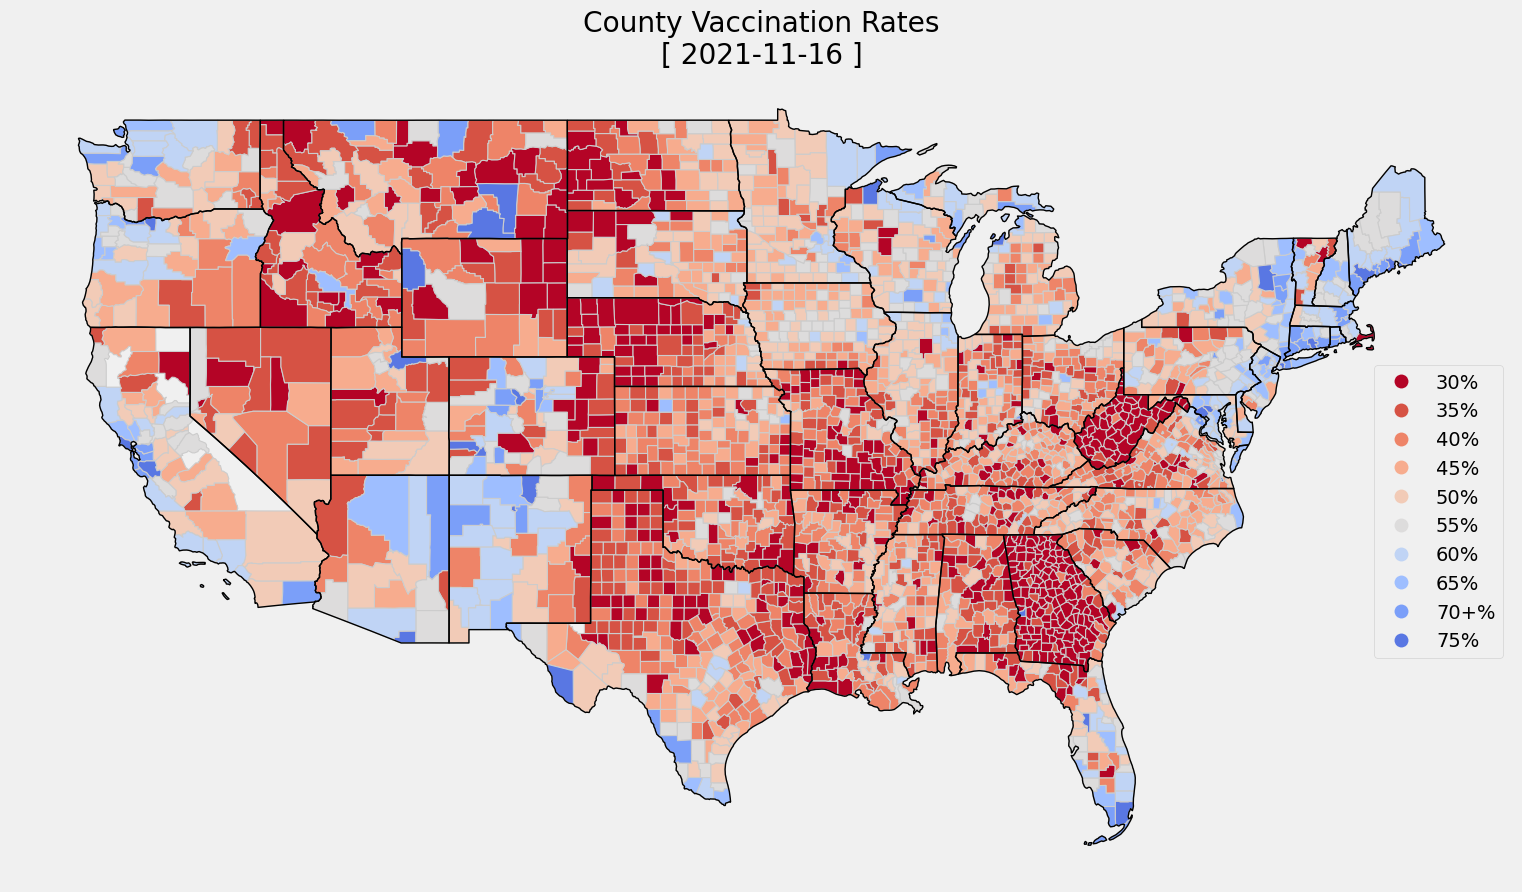

'C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/z_blog_natl_county_vax.jpg'

In [32]:
plot_df = geo_county_tier_df.copy()

plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()


plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Blues(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)

vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")

fig = plt.gcf()
fig.set_size_inches(20,10)


leg = ax.get_legend()


print(dir(leg.get_figure))
print(dir(leg))



leg.set_bbox_to_anchor((1,0.65,0,0))

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)


outfilename=f'z_blog_natl_county_vax.jpg'
              
#out_blog_images.append(outfilename)
fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")



#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"
copy_path = "wk09_10/"
shutil.copyfile(outfilename, f'{directory_path}{copy_path}{outfilename.split("/")[-1]}')



In [35]:
#//*** Associate County FIPS with a TIER value

"""
base_county_tier = geo_county_tier_df.copy()
del base_county_tier['FIPS']
del base_county_tier['tier']

whole_geo_county_tier_df = pd.DataFrame()
for group  in whole_county_tier_df.groupby('Date'):
    ftd = {
        'tier' : [],
        'FIPS' : []
    }
    
    for row in group[1].iterrows():
        for FIPS in row[1]['FIPS']:
            ftd['tier'].append([row[1]['tier']][0])
            ftd['FIPS'].append(FIPS)
    
        tdf = pd.DataFrame()
        
        
        
        tdf['FIPS'] = ftd['FIPS']
        tdf['tier'] = ftd['tier']
        tdf['Date'] = group[0]
        #print(tdf)
        whole_geo_county_tier_df = pd.concat([whole_geo_county_tier_df, base_county_tier.merge(tdf,left_on="GEOID",right_on="FIPS")])
whole_geo_county_tier_df
"""
print()

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_contains', '_custom_handler_map', '_default_contains', '_default_handler_map', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_get_anchored_bb

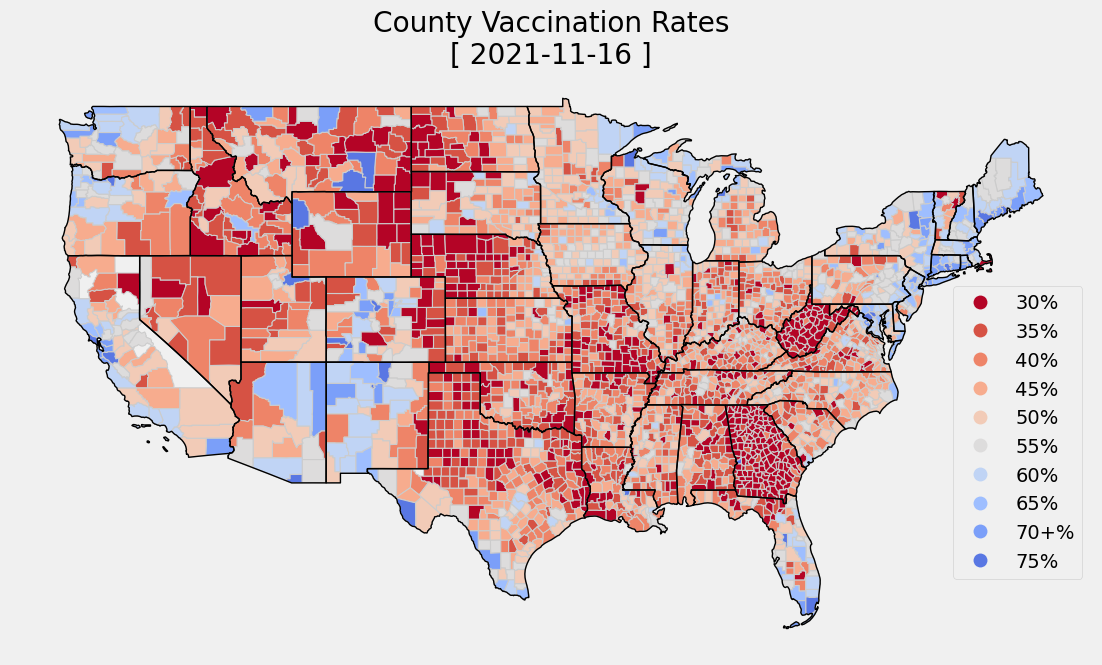

'C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/z_blog_natl_county_vax.jpg'

In [36]:
plot_df = geo_county_tier_df.copy()

plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()

exec_fig_width =1280
exec_fig_height=720

plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Blues(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)

vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")

fig = plt.gcf()

DPI = fig.get_dpi()
    #fig = plt.gcf()
    
fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))

leg = ax.get_legend()


print(dir(leg.get_figure))
print(dir(leg))



leg.set_bbox_to_anchor((1,0.65,0,0))

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)


outfilename=f'z_blog_natl_county_vax.jpg'
              
#out_blog_images.append(outfilename)
fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")



#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"
copy_path = "wk09_10/"
shutil.copyfile(outfilename, f'{directory_path}{copy_path}{outfilename.split("/")[-1]}')



In [37]:
#datetime.strptime(col, "%m/%d/%y").date()
start_summer_date =  datetime(2021, 7, 1).date()
type(whole_county_tier_df['Date'].iloc[0])
start_days = (start_summer_date - county_summary_df['date_start'].min()).days
summer_days = (county_summary_df['date_end'].max() - start_summer_date).days


print(start_days,summer_days)


county_analysis_dict = {
    'start_daily_100k_confirm' : start_summary_df['confirm_period_100k'].astype(int),
    'start_daily_100k_confirm_min' : start_summary_df['confirm_period_100k'].astype(int).min(),
    'start_daily_100k_confirm_max' : start_summary_df['confirm_period_100k'].astype(int).max(),
    'start_daily_mean_confirm' : start_summary_df['confirm_period'] / start_days,
    'summer_daily_mean_confirm': summer_summary_df['confirm_period'] / summer_days,
    'start_daily_mean_death' : start_summary_df['confirm_deaths'] / start_days,
    'summer_daily_mean_death': summer_summary_df['confirm_deaths'] / summer_days,
    'Population' : start_summary_df['Population'].apply(lambda x: f'{x:,}'),
    
    'pop_pct' : round(start_summary_df['pop_pct']*100,1).astype(str)+"%",
    
    'start_day_count' : start_days,
    'summer_day_count' : summer_days,
    'total_day_count' : start_days + summer_days,
    'us_total_vax' : vax_df['Series_Complete_Pop_Pct'].max(),

}

county_analysis_dict['case_change'] =  round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm']))*100,1)
county_analysis_dict['death_change'] = round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death']))*100,1)

county_analysis_dict['case_baseline'] = pd.Series(round( (1- county_analysis_dict['case_change'] /county_analysis_dict['case_change'][0])*100,1))
county_analysis_dict['death_baseline'] = pd.Series(round( (1- county_analysis_dict['death_change']/county_analysis_dict['death_change'][0])*100,1))

county_analysis_dict['case_change'] = county_analysis_dict['case_change'].astype(str)+'%'
county_analysis_dict['death_change'] = county_analysis_dict['death_change'].astype(str)+'%'
"""
print(start_summary_df['confirm_period'] / start_days)
print(summer_summary_df['confirm_period'] / summer_days)

print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm'])))

print(start_summary_df['confirm_deaths'] / start_days)
print(summer_summary_df['confirm_deaths'] / summer_days)
print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death'])))
"""
manage_df['county_analysis_dict'] = "Summary Stats for Display for the blog post"
county_analysis_dict

511 138


{'start_daily_100k_confirm': 0    10247
 1    10801
 2    10640
 3    10682
 4    10623
 5     9765
 6    10096
 7     9939
 8     8314
 9    10882
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 8314,
 'start_daily_100k_confirm_max': 10882,
 'start_daily_mean_confirm': 0     3442.272016
 1     3441.980431
 2     4543.407045
 3     6758.454012
 4    12020.315068
 5    10638.328767
 6    13780.710372
 7     4636.197652
 8     3395.581213
 9     2228.287671
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 10     6433.442029
 11     6779.492754
 12     8931.710145
 13    11991.572464
 14    18513.239130
 15    16767.159420
 16    15818.565217
 17     4915.282609
 18     3363.021739
 19     2291.826087
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     66.205479
 1     66.831703
 2     85.622309
 3    119.418787
 4    198.176125
 5    163.958904
 6    263.925636
 7     87.191781
 8     66.481409
 9     44.669276
 Name: con

In [38]:
county_analysis_dict

{'start_daily_100k_confirm': 0    10247
 1    10801
 2    10640
 3    10682
 4    10623
 5     9765
 6    10096
 7     9939
 8     8314
 9    10882
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 8314,
 'start_daily_100k_confirm_max': 10882,
 'start_daily_mean_confirm': 0     3442.272016
 1     3441.980431
 2     4543.407045
 3     6758.454012
 4    12020.315068
 5    10638.328767
 6    13780.710372
 7     4636.197652
 8     3395.581213
 9     2228.287671
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 10     6433.442029
 11     6779.492754
 12     8931.710145
 13    11991.572464
 14    18513.239130
 15    16767.159420
 16    15818.565217
 17     4915.282609
 18     3363.021739
 19     2291.826087
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     66.205479
 1     66.831703
 2     85.622309
 3    119.418787
 4    198.176125
 5    163.958904
 6    263.925636
 7     87.191781
 8     66.481409
 9     44.669276
 Name: con

In [39]:
state_hosp_tiers_df

population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc                 FIPS      tier total_beds beds_used  \
6001    3579212 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6002    3579212 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6003    3579212 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6004    3579212 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
6005    3579212 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  ID             [16, 54]  total_40        0.0       0.0   
...         ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..                  ...       ...        ...       ...   
3985   13485352 2021-11-12     32433     1614818      7617         29     6057.428571      44.91858        37.000000       0.274372  CT  [9, 23, 25, 44, 50]  total_70    33648.0   28337.0   
3986   13485352 2021-11-13     32443     1616076      6969         33     6438.000000     47.740689        35.142857         0.2606  CT  [9, 23, 25, 44, 50]  total_70    33502.0   27642.0   
3987   13485352 2021-11-14     32443     1616387      1569         10     6466.857143     47.954678        36.000000       0.266956  CT  [9, 23, 25, 44, 50]  total_70    33460.0   27195.0   
3988   13485352 2021-11-15     32490     1625589      9513         47     6875.285714     50.983361        41.857143        0.31039  CT  [9, 23, 25, 44, 50]  total_70    30957.0   25102.0   
3989   13485352 2021-11-16     32529     1630005     13618         86     7458.142857     55.305511        46.000000       0.341111  CT  [9, 23, 25, 44, 50]  total_70    30974.0   25933.0   

     covid_beds_used icu_total           icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
6001             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
6002             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
6003             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
6004             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
6005             0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
...              ...       ...                ...       ...              ...             ...              ...               ...  
3985          1183.0    2925.0  0.631580923258164     291.0           1167.0            16.0         44.91858          0.274372  
3986          1195.0    2913.0  0.629865054482172     287.0           1183.0            12.0        47.740689            0.2606  
3987          1229.0    2902.0   0.60748020428308     278.0           1217.0            12.0        47.954678          0.266956  
3988          1254.0    2861.0  0.716109022720876     285.0           1236.0            18.0        50.983361           0.31039  
3989          1340.0    2901.0  0.707559246297404     295.0           1321.0            19.0        55.305511          0.341111  

[4543 rows x 23 columns]

In [40]:
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

vax_df = vax_df[vax_df["Location"] == 'US' ]
#vax_df['Date'] = 
vax_df['Date'] = pd.to_datetime(vax_df['Date'])

vax_df = vax_df.sort_values('Date')

out_stats

out_stats['total_vaccinated_count'] = format (vax_df.iloc[-1]["Series_Complete_Yes"],',d')
out_stats['total_vaccinated_percent'] = f"{vax_df.iloc[-1]['Series_Complete_Pop_Pct']}%"
out_stats['first_dose_count'] = format (vax_df.iloc[-1]["Administered_Dose1_Recip"],',d')
out_stats['first_dose_percent'] = f"{vax_df.iloc[-1]['Administered_Dose1_Pop_Pct']}%"

manage_df['vax_df'] = "United States Total Vaccine Levels [2020-12-13 - Present]"
vax_df

Date Location  Administered_Dose1_Recip  Administered_Dose1_Pop_Pct  Administered_Dose1_Recip_12Plus  Administered_Dose1_Recip_12PlusPop_Pct  Administered_Dose1_Recip_18Plus  \
21906 2020-12-13       US                         0                         0.0                                0                                     0.0                                0   
21896 2020-12-14       US                         0                         0.0                                0                                     0.0                                0   
21827 2020-12-15       US                         0                         0.0                                0                                     0.0                                0   
21723 2020-12-16       US                         0                         0.0                                0                                     0.0                                0   
21702 2020-12-17       US                         0                         0.0                                0                                     0.0                                0   
...          ...      ...                       ...                         ...                              ...                                     ...                              ...   
311   2021-11-12       US                 225606197                        68.0                        224646990                                    79.2                        209488394   
253   2021-11-13       US                 226157226                        68.1                        224975987                                    79.4                        209794184   
172   2021-11-14       US                 226607653                        68.3                        225254937                                    79.4                        210053318   
96    2021-11-15       US                 227133617                        68.4                        225523235                                    79.5                        210296568   
5     2021-11-16       US                 227691941                        68.6                        225868537                                    79.7                        210620919   

       Administered_Dose1_Recip_18PlusPop_Pct  Administered_Dose1_Recip_65Plus  Administered_Dose1_Recip_65PlusPop_Pct  Series_Complete_Yes  Series_Complete_Pop_Pct  Series_Complete_12Plus  \
21906                                     0.0                                0                                     0.0                    0                      0.0                       0   
21896                                     0.0                                0                                     0.0                    0                      0.0                       0   
21827                                     0.0                                0                                     0.0                    0                      0.0                       0   
21723                                     0.0                                0                                     0.0                    0                      0.0                       0   
21702                                     0.0                                0                                     0.0                    0                      0.0                       0   
...                                       ...                              ...                                     ...                  ...                      ...                     ...   
311                                      81.1                         54120621                                    98.8            194747839                     58.7               194610776   
253                                      81.2                         54210394                                    98.9            194951106                     58.7               194813832   
172            

- [Graph Interactive: U.S. Vaccinations](#graph_us_vaccinations_by_state)


<a id="graph_us_vaccinations_by_state"></a> 
# Graph: U.S. Vaccinations #

- [Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive)](#graph_total_us_vaccination_full_and_partial)


<a id="graph_total_us_vaccination_full_and_partial"></a> 
# Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive) #

- [Graph: List States by Highest Current Death rates (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_death_rates"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: US Total New Deaths Per Day (Line Plot)](#graph_US_total_new_deaths_per_day)


<a id="graph_US_total_new_deaths_per_day"></a> 
# Graph: US Total New Deaths Per Day (Line Plot) #

- [Graph: List States by Highest New Cases (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_new_cases"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: Table of States with Highest Total COVID Counts (Table Plot)](#graph_list_states_highest_total_cases)


<a id="graph_list_states_highest_total_cases"></a> 
# Graph: Table of States with Highest Total COVID Counts (Table Plot) #

- [Graph: U.S. Total COVID Cases Trend (Line Plot)](#graph_us_total_covid_cases_trend)


<a id="graph_us_total_covid_cases_trend"></a> 
# Graph: U.S. Total COVID Cases Trend (Line Plot) #

In [41]:
#plt.get_cmap("Blues")
#//*** Assign Categories for color palettes
plot_cats = geo_county_tier_df['tier'].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


alt_colors = {}
counter = 0
for period in plot_cats:
    alt_colors[period] = colors_palette[counter]
    counter+=1
    
alt_colors


{'total_45': (0.705673158, 0.01555616, 0.150232812, 1.0),
 'total_35': (0.8393649370784314,
  0.32185622094117644,
  0.26492398098039216,
  1.0),
 'total_55': (0.9318312966, 0.5190855232, 0.4064796086, 1.0),
 'total_30': (0.9684997476666667, 0.673977379772549, 0.5566492560470588, 1.0),
 'total_50': (0.9473454036, 0.7946955048, 0.7169905058, 1.0),
 'total_40': (0.8674276350862745, 0.864376599772549, 0.8626024620196079, 1.0),
 'total_75': (0.753610618, 0.830232851, 0.960871157, 1.0),
 'total_60': (0.6193179451882354, 0.7441207347647059, 0.9989309188196078, 1.0),
 'total_65': (0.48385432959999997, 0.6220498496, 0.9748082026, 1.0),
 'total_70': (0.34832334141176474,
  0.4657111465098039,
  0.8883461629411764,
  1.0)}

In [42]:
#tier.replace("total_","")+"%"
colors
if 'geometry' not in geo_county_vax_tier_df.columns:
    print("Merge Geo Data with vax")


    geo_county_vax_tier_df = geo_county_tier_df[["STATEFP","GEOID","geometry"]].merge(geo_county_vax_tier_df,left_on='GEOID',right_on='FIPS')

Merge Geo Data with vax


In [43]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:
        
        if datetime.strptime(date, "%m/%d/%y").date() < start_plot_date:
            continue
        #print(date)
        #if date != "1/13/21":
        #    continue
        
        file_counter += 1
        
        #if file_counter % 50 > 0:
        #    continue

        save_filename = f"{filepath}confirm_hist_{file_counter}.jpg"
        death_filename = f"{filepath}death_hist_{file_counter}.jpg"
        vax_filename = f"{filepath}vax_hist_{file_counter}.jpg"
        
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                #print(f"Skipping: {save_filename}")
                out_controls['copy_files']['infographic_cases'].append(save_filename)
                out_controls['copy_files']['infographic_cases'].append(death_filename)
                out_controls['copy_files']['infographic_cases'].append(vax_filename)
                
                continue

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,4)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_confirm_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(save_filename)
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})

        plt.close()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_death_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(death_filename)
        print(death_filename)
        plt.savefig(death_filename,pil_kwargs={'quality': 90})

        plt.close()
        

        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=70))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"Completed Vaccination",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(vax_filename)
        print(vax_filename)
        plt.savefig(vax_filename,pil_kwargs={'quality': 95})

        plt.close()



    print("Done...")
plt.rcdefaults()

print("Done!")

Working...
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/confirm_hist_649.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/death_hist_649.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/vax_hist_649.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/confirm_hist_650.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/death_hist_650.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/vax_hist_650.jpg
Done...
Done!


In [44]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"

"""
for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")
"""

for key,action in out_controls.items():
    
    
    if key == 'copy_files':
        
        for action_key,action_values in action.items():
            if action_key == "infographic_cases":
                copy_path = "wk09_10/infographic_gifs/"
                
                for filename in action_values:
                    try:
                        print(f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                        shutil.copyfile(filename, f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                    except:
                        continue
                

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_1.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_1.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_1.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_2.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_2.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_2.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_3.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_3.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_3.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_4.jp

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_38.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_38.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_38.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_39.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_39.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_39.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_40.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_40.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_40.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_83.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_83.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_83.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_84.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_84.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_84.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_85.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_85.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_85.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_128.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_128.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_128.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_129.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_129.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_129.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_130.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_130.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_130.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_173.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_173.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_173.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_174.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_174.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_174.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_175.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_175.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_175.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_217.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_217.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_217.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_218.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_218.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_218.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_219.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_219.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_219.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_263.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_264.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_264.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_264.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_265.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_265.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_265.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_266.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_266.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_310.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_311.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_311.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_311.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_312.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_312.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_312.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_313.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_313.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_346.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_346.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_347.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_347.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_347.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_348.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_348.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_348.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_349.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_380.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_380.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_381.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_381.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_381.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_382.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_382.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_382.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_383.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_414.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_414.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_415.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_415.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_415.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_416.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_416.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_416.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_417.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_448.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_448.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_449.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_449.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_449.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_450.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_450.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_450.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_451.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_477.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_477.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_478.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_478.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_478.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_479.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_479.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_479.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_480.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_509.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_509.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_509.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_510.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_510.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_510.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_511.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_511.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_511.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_542.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_542.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_542.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_543.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_543.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_543.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_544.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_544.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_544.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_576.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_576.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_576.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_577.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_577.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_577.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_578.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_578.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_578.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_607.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_608.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_608.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_608.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_609.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_609.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_609.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_610.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_610.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_640.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_641.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_641.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_641.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_642.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_642.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_642.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_643.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_643.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

In [45]:
all_dates

['1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5/20',
 '4/6/20',
 '4/7/20',
 '4/8/20',
 '4/9/20',
 '4/10/20',
 '4/11/20',
 '4/12/20',
 '4/13/20',
 '4/14/20',
 '4/15/20',
 '4/16/20',
 '4/17/20',
 '4/18/20',
 '4/19/20',
 '4/20/20',
 '4/21/20',
 '4/22/20',
 '4/23/

Working...


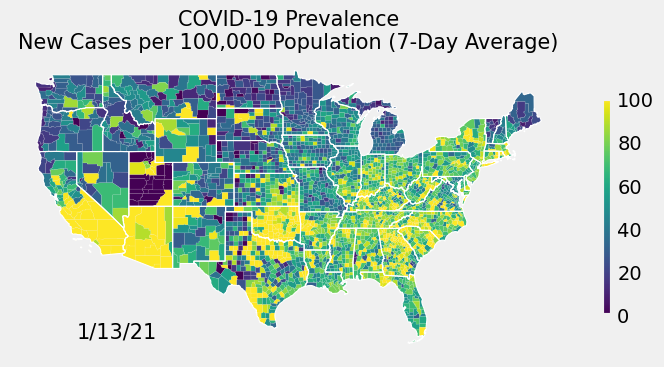

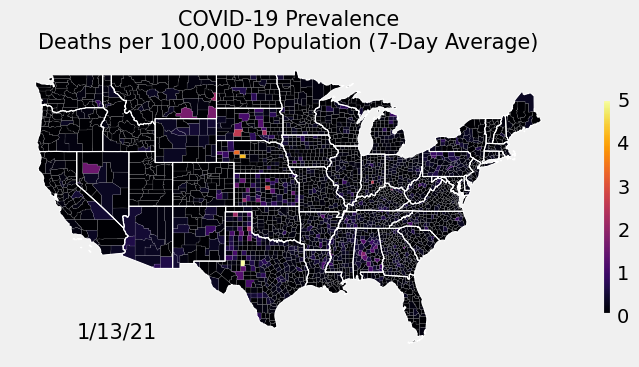

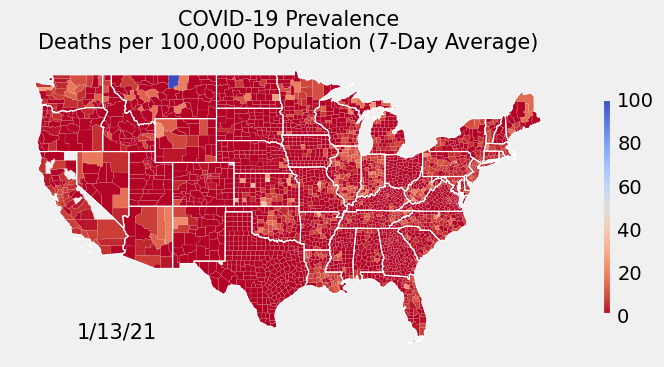

Done...
Done!


In [46]:
#2021/01/13


("1/13/21" in all_dates)



#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in ["1/13/21"]:
        

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.savefig("test.jpg",pil_kwargs={'quality': 95})
        plt.show()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()
     #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()



    print("Done...")
plt.rcdefaults()

print("Done!")

In [ ]:
#HERE

In [78]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')

exec_fig_width =1280
exec_fig_height=720
fontsize=15
#figsize=(600*px, 200*px)
base_confirm_path = "./final_video/1_confirm/"
base_confirm_filename = "_confirm.jpg"

base_death_path = "./final_video/1_death/"
base_death_filename = "_death.jpg"

base_vax_path = "./final_video/1_vax/"
base_vax_filename = "_vax.jpg"

    

start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:
        
        if datetime.strptime(date, "%m/%d/%y").date() < start_plot_date:
            continue
        #print(date)
        #if date != "1/13/21":
        #    continue
        
        file_counter += 1
        
        #if file_counter % 50 > 0:
        #    continue

        save_filename = f"{base_confirm_path}{file_counter}{base_confirm_filename}"
        death_filename = f"{base_death_path}{file_counter}{base_death_filename}"
        vax_filename = f"{base_vax_path}{file_counter}{base_vax_filename}"
        
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                continue

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()
        fig = plt.gcf()
        DPI = fig.get_dpi()
        fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))
        
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_confirm_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})

        plt.close()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()
        fig = plt.gcf()
        DPI = fig.get_dpi()
        fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))

        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_death_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        print(death_filename)
        plt.savefig(death_filename,pil_kwargs={'quality': 95})

        plt.close()
        

        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()
        fig = plt.gcf()
        DPI = fig.get_dpi()
        fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))

        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=70))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"Completed Vaccination",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        print(vax_filename)
        plt.savefig(vax_filename,pil_kwargs={'quality': 95})

        plt.close()

        

    print("Done...")
plt.rcdefaults()

print("Done!")

Working...
./final_video/1_confirm/1_confirm.jpg
./final_video/1_death/1_death.jpg
./final_video/1_confirm/2_confirm.jpg
./final_video/1_death/2_death.jpg
./final_video/1_confirm/3_confirm.jpg
./final_video/1_death/3_death.jpg
./final_video/1_confirm/4_confirm.jpg
./final_video/1_death/4_death.jpg
./final_video/1_confirm/5_confirm.jpg
./final_video/1_death/5_death.jpg
./final_video/1_confirm/6_confirm.jpg
./final_video/1_death/6_death.jpg
./final_video/1_confirm/7_confirm.jpg
./final_video/1_death/7_death.jpg
./final_video/1_confirm/8_confirm.jpg
./final_video/1_death/8_death.jpg
./final_video/1_confirm/9_confirm.jpg
./final_video/1_death/9_death.jpg
./final_video/1_confirm/10_confirm.jpg
./final_video/1_death/10_death.jpg
./final_video/1_confirm/11_confirm.jpg
./final_video/1_death/11_death.jpg
./final_video/1_confirm/12_confirm.jpg
./final_video/1_death/12_death.jpg
./final_video/1_confirm/13_confirm.jpg
./final_video/1_death/13_death.jpg
./final_video/1_confirm/14_confirm.jpg
./fina

./final_video/1_death/111_death.jpg
./final_video/1_confirm/112_confirm.jpg
./final_video/1_death/112_death.jpg
./final_video/1_confirm/113_confirm.jpg
./final_video/1_death/113_death.jpg
./final_video/1_confirm/114_confirm.jpg
./final_video/1_death/114_death.jpg
./final_video/1_confirm/115_confirm.jpg
./final_video/1_death/115_death.jpg
./final_video/1_confirm/116_confirm.jpg
./final_video/1_death/116_death.jpg
./final_video/1_confirm/117_confirm.jpg
./final_video/1_death/117_death.jpg
./final_video/1_confirm/118_confirm.jpg
./final_video/1_death/118_death.jpg
./final_video/1_confirm/119_confirm.jpg
./final_video/1_death/119_death.jpg
./final_video/1_confirm/120_confirm.jpg
./final_video/1_death/120_death.jpg
./final_video/1_confirm/121_confirm.jpg
./final_video/1_death/121_death.jpg
./final_video/1_confirm/122_confirm.jpg
./final_video/1_death/122_death.jpg
./final_video/1_confirm/123_confirm.jpg
./final_video/1_death/123_death.jpg
./final_video/1_confirm/124_confirm.jpg
./final_vide

./final_video/1_death/219_death.jpg
./final_video/1_confirm/220_confirm.jpg
./final_video/1_death/220_death.jpg
./final_video/1_confirm/221_confirm.jpg
./final_video/1_death/221_death.jpg
./final_video/1_confirm/222_confirm.jpg
./final_video/1_death/222_death.jpg
./final_video/1_confirm/223_confirm.jpg
./final_video/1_death/223_death.jpg
./final_video/1_confirm/224_confirm.jpg
./final_video/1_death/224_death.jpg
./final_video/1_confirm/225_confirm.jpg
./final_video/1_death/225_death.jpg
./final_video/1_confirm/226_confirm.jpg
./final_video/1_death/226_death.jpg
./final_video/1_confirm/227_confirm.jpg
./final_video/1_death/227_death.jpg
./final_video/1_confirm/228_confirm.jpg
./final_video/1_death/228_death.jpg
./final_video/1_confirm/229_confirm.jpg
./final_video/1_death/229_death.jpg
./final_video/1_confirm/230_confirm.jpg
./final_video/1_death/230_death.jpg
./final_video/1_confirm/231_confirm.jpg
./final_video/1_death/231_death.jpg
./final_video/1_confirm/232_confirm.jpg
./final_vide

./final_video/1_confirm/323_confirm.jpg
./final_video/1_death/323_death.jpg
./final_video/1_vax/323_vax.jpg
./final_video/1_confirm/324_confirm.jpg
./final_video/1_death/324_death.jpg
./final_video/1_vax/324_vax.jpg
./final_video/1_confirm/325_confirm.jpg
./final_video/1_death/325_death.jpg
./final_video/1_vax/325_vax.jpg
./final_video/1_confirm/326_confirm.jpg
./final_video/1_death/326_death.jpg
./final_video/1_vax/326_vax.jpg
./final_video/1_confirm/327_confirm.jpg
./final_video/1_death/327_death.jpg
./final_video/1_vax/327_vax.jpg
./final_video/1_confirm/328_confirm.jpg
./final_video/1_death/328_death.jpg
./final_video/1_vax/328_vax.jpg
./final_video/1_confirm/329_confirm.jpg
./final_video/1_death/329_death.jpg
./final_video/1_vax/329_vax.jpg
./final_video/1_confirm/330_confirm.jpg
./final_video/1_death/330_death.jpg
./final_video/1_vax/330_vax.jpg
./final_video/1_confirm/331_confirm.jpg
./final_video/1_death/331_death.jpg
./final_video/1_vax/331_vax.jpg
./final_video/1_confirm/332_

./final_video/1_confirm/399_confirm.jpg
./final_video/1_death/399_death.jpg
./final_video/1_vax/399_vax.jpg
./final_video/1_confirm/400_confirm.jpg
./final_video/1_death/400_death.jpg
./final_video/1_vax/400_vax.jpg
./final_video/1_confirm/401_confirm.jpg
./final_video/1_death/401_death.jpg
./final_video/1_vax/401_vax.jpg
./final_video/1_confirm/402_confirm.jpg
./final_video/1_death/402_death.jpg
./final_video/1_vax/402_vax.jpg
./final_video/1_confirm/403_confirm.jpg
./final_video/1_death/403_death.jpg
./final_video/1_vax/403_vax.jpg
./final_video/1_confirm/404_confirm.jpg
./final_video/1_death/404_death.jpg
./final_video/1_vax/404_vax.jpg
./final_video/1_confirm/405_confirm.jpg
./final_video/1_death/405_death.jpg
./final_video/1_vax/405_vax.jpg
./final_video/1_confirm/406_confirm.jpg
./final_video/1_death/406_death.jpg
./final_video/1_vax/406_vax.jpg
./final_video/1_confirm/407_confirm.jpg
./final_video/1_death/407_death.jpg
./final_video/1_vax/407_vax.jpg
./final_video/1_confirm/408_

./final_video/1_confirm/475_confirm.jpg
./final_video/1_death/475_death.jpg
./final_video/1_vax/475_vax.jpg
./final_video/1_confirm/476_confirm.jpg
./final_video/1_death/476_death.jpg
./final_video/1_vax/476_vax.jpg
./final_video/1_confirm/477_confirm.jpg
./final_video/1_death/477_death.jpg
./final_video/1_vax/477_vax.jpg
./final_video/1_confirm/478_confirm.jpg
./final_video/1_death/478_death.jpg
./final_video/1_vax/478_vax.jpg
./final_video/1_confirm/479_confirm.jpg
./final_video/1_death/479_death.jpg
./final_video/1_vax/479_vax.jpg
./final_video/1_confirm/480_confirm.jpg
./final_video/1_death/480_death.jpg
./final_video/1_vax/480_vax.jpg
./final_video/1_confirm/481_confirm.jpg
./final_video/1_death/481_death.jpg
./final_video/1_vax/481_vax.jpg
./final_video/1_confirm/482_confirm.jpg
./final_video/1_death/482_death.jpg
./final_video/1_vax/482_vax.jpg
./final_video/1_confirm/483_confirm.jpg
./final_video/1_death/483_death.jpg
./final_video/1_vax/483_vax.jpg
./final_video/1_confirm/484_

./final_video/1_confirm/551_confirm.jpg
./final_video/1_death/551_death.jpg
./final_video/1_vax/551_vax.jpg
./final_video/1_confirm/552_confirm.jpg
./final_video/1_death/552_death.jpg
./final_video/1_vax/552_vax.jpg
./final_video/1_confirm/553_confirm.jpg
./final_video/1_death/553_death.jpg
./final_video/1_vax/553_vax.jpg
./final_video/1_confirm/554_confirm.jpg
./final_video/1_death/554_death.jpg
./final_video/1_vax/554_vax.jpg
./final_video/1_confirm/555_confirm.jpg
./final_video/1_death/555_death.jpg
./final_video/1_vax/555_vax.jpg
./final_video/1_confirm/556_confirm.jpg
./final_video/1_death/556_death.jpg
./final_video/1_vax/556_vax.jpg
./final_video/1_confirm/557_confirm.jpg
./final_video/1_death/557_death.jpg
./final_video/1_vax/557_vax.jpg
./final_video/1_confirm/558_confirm.jpg
./final_video/1_death/558_death.jpg
./final_video/1_vax/558_vax.jpg
./final_video/1_confirm/559_confirm.jpg
./final_video/1_death/559_death.jpg
./final_video/1_vax/559_vax.jpg
./final_video/1_confirm/560_

./final_video/1_confirm/627_confirm.jpg
./final_video/1_death/627_death.jpg
./final_video/1_vax/627_vax.jpg
./final_video/1_confirm/628_confirm.jpg
./final_video/1_death/628_death.jpg
./final_video/1_vax/628_vax.jpg
./final_video/1_confirm/629_confirm.jpg
./final_video/1_death/629_death.jpg
./final_video/1_vax/629_vax.jpg
./final_video/1_confirm/630_confirm.jpg
./final_video/1_death/630_death.jpg
./final_video/1_vax/630_vax.jpg
./final_video/1_confirm/631_confirm.jpg
./final_video/1_death/631_death.jpg
./final_video/1_vax/631_vax.jpg
./final_video/1_confirm/632_confirm.jpg
./final_video/1_death/632_death.jpg
./final_video/1_vax/632_vax.jpg
./final_video/1_confirm/633_confirm.jpg
./final_video/1_death/633_death.jpg
./final_video/1_vax/633_vax.jpg
./final_video/1_confirm/634_confirm.jpg
./final_video/1_death/634_death.jpg
./final_video/1_vax/634_vax.jpg
./final_video/1_confirm/635_confirm.jpg
./final_video/1_death/635_death.jpg
./final_video/1_vax/635_vax.jpg
./final_video/1_confirm/636_

In [47]:
"""
linewidth=.2
counter = 0
for tier in geo_county_tier_df['tier'].unique():
    counter += 1
    temp_plot = geo_county_tier_df[geo_county_tier_df['tier'] == tier]

    if counter > 3:
        linewidth+=.2


    ax = temp_plot.plot(categorical=True,legend=True, linewidth=linewidth,edgecolor=alt_colors[tier],color=(1,1,1,0),ax=ax)

#geo_county_tier_df

temp_plot = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]

if len(temp_plot) > 0:
    #ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, linewidth=linewidth,cmap=plt.get_cmap("viridis"),color=(1,1,1,0),ax=ax)
    ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, marker='.', linewidth=linewidth,cmap=plt.get_cmap("Blues"),markersize=1,ax=ax)
"""

geo_county_vax_tier_df
print(attrib_death_df)

     STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Deaths  1/29/20_New_Deaths_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                   0                            0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                   0                            0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                   0                            0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                   0                            0   
4         48  48459    Up

In [48]:
attrib_confirm_df['1/5/21_scaled_100k'].max()

100

In [49]:


#//********************************************
#//*** Build Confirmed Historical Slider Plot
#//********************************************
plot_df = attrib_confirm_df.copy()
    

slider_columns = [f"{x}_scaled_100k" for x in all_dates]

slider_range = all_dates
slider_range = [i for i in range(0,len(all_dates))]

#hover_cols = ["Population","Loc"]
#for x in [x*(int(len(all_dates)/8)) for x in range(1,9)]:
#    hover_cols.append(f"{all_dates[x]}_New_Cases")
#    hover_cols.append(f"{all_dates[x]}_New_Cases_per_100k")
hover_cols = ["Population","Loc"]

tooltips =[
   ("index", "$index"),    
   ( "Date",  "@Date" ),
   ("Value", "$y{0}/Day"),
]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    #category="scale_100k",
    title = f"U.S. COVID Prevalence (Cases per 100k Population): {all_dates[0]} - {all_dates[-1]}",
    slider=slider_columns,
    slider_range = slider_range,
    slider_name = slider_name,
    toolbar_location=None,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    hovertool_columns=hover_cols,
    #tooltips=tooltips,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
#out_plot['confirm_historical'] = out_html

In [50]:
county_tier_df

Date                                               FIPS      Admin2 Province_State             Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
334  2020-12-21  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786      954194      16261       15459        104    21495.000000   
335  2020-12-22  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786      967150      16460       19684        244    21600.857143   
336  2020-12-23  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786      979108      16641       24914        380    21732.428571   
337  2020-12-24  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786      992810      16808       25660        348    21901.000000   
338  2020-12-25  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786     1000340      16897       21232        256    21207.428571   
..          ...                                                ...         ...            ...                      ...        ...         ...        ...         ...        ...             ...   
660  2021-11-12  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1451337      23478        3499         10     2268.142857   
661  2021-11-13  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452168      23491        3673         22     2380.571429   
662  2021-11-14  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452313      23492         976         14     2334.000000   
663  2021-11-15  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1454174      23502        2006         11     2264.857143   
664  2021-11-16  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1455117      23511        2804         19     2345.142857   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k total_vaccinated_percent total_vaccinated_count first_dose_pct first_dose_count      tier  
334       260.857143    125.220016       1.519634              100          1.519634                      0.0                      0            0.0              0.0  total_30  
335       261.285714    125.836691       1.522131              100          1.522131                      0.0                      0            0.0              0.0  total_30  
336       266.285714    126.603166       1.551258              100          1.551258                      0.0                      0            0.0              0.0  total_30  
337       265.571429    127.585186       1.547097              100          1.547097                      0.0                      0            0.0              0.0  total_30  
338       259.428571    123.544757       1.511312              100          1.511312                      0.0                      0            0.0              0.0  total_30  
..               ...           ...            ...              ...               ...                      ...                    ...            ...              ...       ...  
660        10.714286     21.676549       0.102396        21.676549          0.102396                76.724675                8028147      87.162069        9120272.0  total_75  
661        12.142857     22.751025       0.116049        22.751025          0.116049                      100               16070786            100       18279742.0  total_75  
662        13.714286     22.305943       0.131067        22.305943          0

- [Graph: Infographic Visualization](#infographic_visualization)


<a id="infographic_visualization"></a> 
# Graph: Infographic Visualization #

In [51]:
geo_county_vax_tier_df['Date'].iloc[1]

datetime.date(2021, 11, 15)

In [52]:
import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()
    
out_master = {}

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily","total_vaccinated_percent"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in whole_county_tier_df['Date'].unique():
    #if date >= start_summer_date:
    #    break
    loop_df = whole_county_tier_df[whole_county_tier_df['Date'] == date].copy()
    loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date].copy()
    
   
    
    
    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_confirm)
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                
                case_100k_avg_daily = round(tot_confirm / (pop / 100000),4)
                case_100k_avg_daily = round(case_100k_avg_daily / days,4)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,2)
                td[col].append(death_100k_avg_daily)
                continue
                
            if col == "total_vaccinated_percent":
                #//**** No Vaccaination Data Yet
                #loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date]
                #total_vaccinated_percent = "0%"
                #td[col].append("0%")
                if len(loop_vax_df) == 0:
                    total_vaccinated_percent = "0.0%"
                    td[col].append("0%")
                else:
                    #print(geo_county_vax_tier_df)
                    
                    total_vaccinated_percent = loop_vax_df[loop_vax_df['tier'] == tier][col].values[0]
                    total_vaccinated_percent = str(total_vaccinated_percent) + "%"
                    td[col].append(total_vaccinated_percent)
                continue

    #print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm,total_vaccinated_percent)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['New_Confirm'][x],td['tier'][x],td['case_100k_avg'][x],td["relative_confirm_100k"][x],td['total_vaccinated_percent'][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_left'] = {
    'filename' : 'infographic_left.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_left = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
last_date = td['Date'][-1]
print("Done!")

0 2020/02/06 total_30 0 total_30 0.0 0% 0%
1 2020/02/06 total_35 0 total_35 0.0 0% 0%
2 2020/02/06 total_40 0 total_40 0.0 0% 0%
3 2020/02/06 total_45 0 total_45 0.0 0% 0%
4 2020/02/06 total_50 0 total_50 0.0 0% 0%
5 2020/02/06 total_55 0 total_55 0.0 0% 0%
6 2020/02/06 total_60 1 total_60 0.0014 0% 0%
7 2020/02/06 total_65 0 total_65 0.0 0% 0%
8 2020/02/06 total_70 0 total_70 0.0 0% 0%
9 2020/02/06 total_75 0 total_75 0.0 0% 0%
10 2020/02/07 total_30 0 total_30 0.0 0% 0%
11 2020/02/07 total_35 0 total_35 0.0 0% 0%
12 2020/02/07 total_40 0 total_40 0.0 0% 0%
13 2020/02/07 total_45 0 total_45 0.0 0% 0%
14 2020/02/07 total_50 0 total_50 0.0 0% 0%
15 2020/02/07 total_55 0 total_55 0.0 0% 0%
16 2020/02/07 total_60 1 total_60 0.0014 0% 0%
17 2020/02/07 total_65 0 total_65 0.0 0% 0%
18 2020/02/07 total_70 0 total_70 0.0 0% 0%
19 2020/02/07 total_75 0 total_75 0.0 0% 0%
20 2020/02/08 total_30 0 total_30 0.0 0% 0%
21 2020/02/08 total_35 0 total_35 0.0 0% 0%
22 2020/02/08 total_40 0 total_40 0.

270 2020/03/04 total_30 2 total_30 0.0117 100.0% 0%
271 2020/03/04 total_35 0 total_35 0.0 0.0% 0%
272 2020/03/04 total_40 0 total_40 0.0 0.0% 0%
273 2020/03/04 total_45 0 total_45 0.0 0.0% 0%
274 2020/03/04 total_50 1 total_50 0.0017 14.53% 0%
275 2020/03/04 total_55 1 total_55 0.0018 15.38% 0%
276 2020/03/04 total_60 13 total_60 0.0186 158.97% 0%
277 2020/03/04 total_65 4 total_65 0.0168 143.59% 0%
278 2020/03/04 total_70 30 total_70 0.1438 1229.06% 0%
279 2020/03/04 total_75 5 total_75 0.0478 408.55% 0%
280 2020/03/05 total_30 0 total_30 0.0 0% 0%
281 2020/03/05 total_35 0 total_35 0.0 0% 0%
282 2020/03/05 total_40 0 total_40 0.0 0% 0%
283 2020/03/05 total_45 1 total_45 0.0031 0% 0%
284 2020/03/05 total_50 4 total_50 0.0069 0% 0%
285 2020/03/05 total_55 4 total_55 0.0072 0% 0%
286 2020/03/05 total_60 27 total_60 0.0387 0% 0%
287 2020/03/05 total_65 7 total_65 0.0294 0% 0%
288 2020/03/05 total_70 57 total_70 0.2731 0% 0%
289 2020/03/05 total_75 5 total_75 0.0478 0% 0%
290 2020/03/06 

520 2020/03/29 total_30 688 total_30 4.008 100.0% 0%
521 2020/03/29 total_35 442 total_35 2.7145 67.73% 0%
522 2020/03/29 total_40 701 total_40 3.2127 80.16% 0%
523 2020/03/29 total_45 2201 total_45 6.8081 169.86% 0%
524 2020/03/29 total_50 2290 total_50 3.9607 98.82% 0%
525 2020/03/29 total_55 4614 total_55 8.2884 206.8% 0%
526 2020/03/29 total_60 11139 total_60 15.9707 398.47% 0%
527 2020/03/29 total_65 4965 total_65 20.8297 519.7% 0%
528 2020/03/29 total_70 6469 total_70 30.9984 773.41% 0%
529 2020/03/29 total_75 3142 total_75 30.028 749.2% 0%
530 2020/03/30 total_30 671 total_30 3.9089 100.0% 0%
531 2020/03/30 total_35 468 total_35 2.8742 73.53% 0%
532 2020/03/30 total_40 722 total_40 3.3089 84.65% 0%
533 2020/03/30 total_45 2162 total_45 6.6875 171.08% 0%
534 2020/03/30 total_50 2585 total_50 4.471 114.38% 0%
535 2020/03/30 total_55 4097 total_55 7.3596 188.28% 0%
536 2020/03/30 total_60 11673 total_60 16.7363 428.16% 0%
537 2020/03/30 total_65 5454 total_65 22.8812 585.36% 0%
538

810 2020/04/27 total_30 1328 total_30 7.7363 100.0% 0%
811 2020/04/27 total_35 1228 total_35 7.5418 97.49% 0%
812 2020/04/27 total_40 2552 total_40 11.6959 151.18% 0%
813 2020/04/27 total_45 2859 total_45 8.8435 114.31% 0%
814 2020/04/27 total_50 4296 total_50 7.4303 96.04% 0%
815 2020/04/27 total_55 6263 total_55 11.2505 145.42% 0%
816 2020/04/27 total_60 15622 total_60 22.3982 289.52% 0%
817 2020/04/27 total_65 6947 total_65 29.1449 376.73% 0%
818 2020/04/27 total_70 5841 total_70 27.9891 361.79% 0%
819 2020/04/27 total_75 2913 total_75 27.8394 359.85% 0%
820 2020/04/28 total_30 1712 total_30 9.9733 100.0% 0%
821 2020/04/28 total_35 1334 total_35 8.1928 82.15% 0%
822 2020/04/28 total_40 2456 total_40 11.2559 112.86% 0%
823 2020/04/28 total_45 2774 total_45 8.5805 86.03% 0%
824 2020/04/28 total_50 4878 total_50 8.4369 84.59% 0%
825 2020/04/28 total_55 6815 total_55 12.2421 122.75% 0%
826 2020/04/28 total_60 14686 total_60 21.0562 211.13% 0%
827 2020/04/28 total_65 6245 total_65 26.199

1082 2020/05/24 total_40 1855 total_40 8.5015 83.01% 0%
1083 2020/05/24 total_45 3004 total_45 9.292 90.73% 0%
1084 2020/05/24 total_50 5182 total_50 8.9627 87.52% 0%
1085 2020/05/24 total_55 6522 total_55 11.7158 114.4% 0%
1086 2020/05/24 total_60 12321 total_60 17.6654 172.49% 0%
1087 2020/05/24 total_65 4169 total_65 17.4903 170.78% 0%
1088 2020/05/24 total_70 2638 total_70 12.6409 123.43% 0%
1089 2020/05/24 total_75 1796 total_75 17.1643 167.6% 0%
1090 2020/05/25 total_30 1948 total_30 11.3482 100.0% 0%
1091 2020/05/25 total_35 1720 total_35 10.5634 93.08% 0%
1092 2020/05/25 total_40 2005 total_40 9.189 80.97% 0%
1093 2020/05/25 total_45 2868 total_45 8.8713 78.17% 0%
1094 2020/05/25 total_50 4966 total_50 8.5891 75.69% 0%
1095 2020/05/25 total_55 5805 total_55 10.4278 91.89% 0%
1096 2020/05/25 total_60 11804 total_60 16.9241 149.13% 0%
1097 2020/05/25 total_65 3676 total_65 15.422 135.9% 0%
1098 2020/05/25 total_70 2677 total_70 12.8277 113.04% 0%
1099 2020/05/25 total_75 1633 tot

1394 2020/06/24 total_50 14927 total_50 25.8174 88.88% 0%
1395 2020/06/24 total_55 14080 total_55 25.2926 87.08% 0%
1396 2020/06/24 total_60 15322 total_60 21.9681 75.63% 0%
1397 2020/06/24 total_65 2818 total_65 11.8224 40.7% 0%
1398 2020/06/24 total_70 2289 total_70 10.9685 37.76% 0%
1399 2020/06/24 total_75 2663 total_75 25.4502 87.62% 0%
1400 2020/06/25 total_30 4187 total_30 24.3915 100.0% 0%
1401 2020/06/25 total_35 4128 total_35 25.3521 103.94% 0%
1402 2020/06/25 total_40 4668 total_40 21.3936 87.71% 0%
1403 2020/06/25 total_45 7584 total_45 23.4589 96.18% 0%
1404 2020/06/25 total_50 15592 total_50 26.9676 110.56% 0%
1405 2020/06/25 total_55 15421 total_55 27.7015 113.57% 0%
1406 2020/06/25 total_60 16008 total_60 22.9517 94.1% 0%
1407 2020/06/25 total_65 2650 total_65 11.1176 45.58% 0%
1408 2020/06/25 total_70 1914 total_70 9.1716 37.6% 0%
1409 2020/06/25 total_75 2900 total_75 27.7152 113.63% 0%
1410 2020/06/26 total_30 4121 total_30 24.0071 100.0% 0%
1411 2020/06/26 total_35 

1707 2020/07/25 total_65 6839 total_65 28.6918 51.53% 0%
1708 2020/07/25 total_70 3585 total_70 17.1787 30.86% 0%
1709 2020/07/25 total_75 8237 total_75 78.7207 141.39% 0%
1710 2020/07/26 total_30 7572 total_30 44.111 100.0% 0%
1711 2020/07/26 total_35 7415 total_35 45.5392 103.24% 0%
1712 2020/07/26 total_40 8028 total_40 36.7925 83.41% 0%
1713 2020/07/26 total_45 12984 total_45 40.1622 91.05% 0%
1714 2020/07/26 total_50 25780 total_50 44.5885 101.08% 0%
1715 2020/07/26 total_55 20148 total_55 36.1928 82.05% 0%
1716 2020/07/26 total_60 22496 total_60 32.2539 73.12% 0%
1717 2020/07/26 total_65 5623 total_65 23.5903 53.48% 0%
1718 2020/07/26 total_70 2610 total_70 12.5067 28.35% 0%
1719 2020/07/26 total_75 7726 total_75 73.8371 167.39% 0%
1720 2020/07/27 total_30 6163 total_30 35.9028 100.0% 0%
1721 2020/07/27 total_35 7804 total_35 47.9282 133.49% 0%
1722 2020/07/27 total_40 7867 total_40 36.0547 100.42% 0%
1723 2020/07/27 total_45 12409 total_45 38.3836 106.91% 0%
1724 2020/07/27 tota

2019 2020/08/25 total_75 2510 total_75 23.988 65.42% 0%
2020 2020/08/26 total_30 7661 total_30 44.6295 100.0% 0%
2021 2020/08/26 total_35 7610 total_35 46.7368 104.72% 0%
2022 2020/08/26 total_40 6661 total_40 30.5275 68.4% 0%
2023 2020/08/26 total_45 10040 total_45 31.0558 69.59% 0%
2024 2020/08/26 total_50 14761 total_50 25.5303 57.2% 0%
2025 2020/08/26 total_55 12858 total_55 23.0975 51.75% 0%
2026 2020/08/26 total_60 13697 total_60 19.6382 44.0% 0%
2027 2020/08/26 total_65 4765 total_65 19.9907 44.79% 0%
2028 2020/08/26 total_70 3125 total_70 14.9745 33.55% 0%
2029 2020/08/26 total_75 2654 total_75 25.3642 56.83% 0%
2030 2020/08/27 total_30 7568 total_30 44.0877 100.0% 0%
2031 2020/08/27 total_35 7305 total_35 44.8636 101.76% 0%
2032 2020/08/27 total_40 7176 total_40 32.8878 74.6% 0%
2033 2020/08/27 total_45 10823 total_45 33.4777 75.93% 0%
2034 2020/08/27 total_50 15539 total_50 26.8759 60.96% 0%
2035 2020/08/27 total_55 13928 total_55 25.0195 56.75% 0%
2036 2020/08/27 total_60 15

2332 2020/09/26 total_40 8783 total_40 40.2527 101.66% 0%
2333 2020/09/26 total_45 11385 total_45 35.2161 88.94% 0%
2334 2020/09/26 total_50 17103 total_50 29.581 74.71% 0%
2335 2020/09/26 total_55 17078 total_55 30.678 77.48% 0%
2336 2020/09/26 total_60 14351 total_60 20.5759 51.96% 0%
2337 2020/09/26 total_65 4671 total_65 19.5963 49.49% 0%
2338 2020/09/26 total_70 2838 total_70 13.5992 34.34% 0%
2339 2020/09/26 total_75 1945 total_75 18.5883 46.94% 0%
2340 2020/09/27 total_30 4904 total_30 28.5685 100.0% 0%
2341 2020/09/27 total_35 5886 total_35 36.1488 126.53% 0%
2342 2020/09/27 total_40 7087 total_40 32.4799 113.69% 0%
2343 2020/09/27 total_45 9916 total_45 30.6722 107.36% 0%
2344 2020/09/27 total_50 15724 total_50 27.1959 95.2% 0%
2345 2020/09/27 total_55 14154 total_55 25.4255 89.0% 0%
2346 2020/09/27 total_60 14660 total_60 21.0189 73.57% 0%
2347 2020/09/27 total_65 4502 total_65 18.8873 66.11% 0%
2348 2020/09/27 total_70 2545 total_70 12.1952 42.69% 0%
2349 2020/09/27 total_75

2644 2020/10/27 total_50 25214 total_50 43.6096 119.6% 0%
2645 2020/10/27 total_55 25071 total_55 45.0363 123.52% 0%
2646 2020/10/27 total_60 23007 total_60 32.9866 90.47% 0%
2647 2020/10/27 total_65 12277 total_65 51.5059 141.26% 0%
2648 2020/10/27 total_70 5680 total_70 27.2176 74.65% 0%
2649 2020/10/27 total_75 2822 total_75 26.9697 73.97% 0%
2650 2020/10/28 total_30 7575 total_30 44.1285 100.0% 0%
2651 2020/10/28 total_35 10615 total_35 65.192 147.73% 0%
2652 2020/10/28 total_40 13988 total_40 64.1074 145.27% 0%
2653 2020/10/28 total_45 18836 total_45 58.2636 132.03% 0%
2654 2020/10/28 total_50 27712 total_50 47.9301 108.61% 0%
2655 2020/10/28 total_55 27794 total_55 49.9277 113.14% 0%
2656 2020/10/28 total_60 27027 total_60 38.7503 87.81% 0%
2657 2020/10/28 total_65 11931 total_65 50.0543 113.43% 0%
2658 2020/10/28 total_70 5730 total_70 27.4572 62.22% 0%
2659 2020/10/28 total_75 2846 total_75 27.1991 61.64% 0%
2660 2020/10/29 total_30 7685 total_30 44.7693 100.0% 0%
2661 2020/10/

2957 2020/11/27 total_65 23704 total_65 99.4458 122.67% 0%
2958 2020/11/27 total_70 14121 total_70 67.6655 83.47% 0%
2959 2020/11/27 total_75 8030 total_75 76.7424 94.66% 0%
2960 2020/11/28 total_30 12820 total_30 74.6834 100.0% 0%
2961 2020/11/28 total_35 19241 total_35 118.1685 158.23% 0%
2962 2020/11/28 total_40 27200 total_40 124.6583 166.92% 0%
2963 2020/11/28 total_45 41564 total_45 128.5659 172.15% 0%
2964 2020/11/28 total_50 64893 total_50 112.2375 150.28% 0%
2965 2020/11/28 total_55 67072 total_55 120.4847 161.33% 0%
2966 2020/11/28 total_60 65469 total_60 93.8669 125.69% 0%
2967 2020/11/28 total_65 25184 total_65 105.6548 141.47% 0%
2968 2020/11/28 total_70 15592 total_70 74.7143 100.04% 0%
2969 2020/11/28 total_75 9923 total_75 94.8337 126.98% 0%
2970 2020/11/29 total_30 11021 total_30 64.2033 100.0% 0%
2971 2020/11/29 total_35 15155 total_35 93.0743 144.97% 0%
2972 2020/11/29 total_40 21352 total_40 97.8568 152.42% 0%
2973 2020/11/29 total_45 31154 total_45 96.3657 150.09% 

3269 2020/12/28 total_75 9987 total_75 95.4454 139.0% 0.0%
3270 2020/12/29 total_30 19977 total_30 116.3768 100.0% 0.0%
3271 2020/12/29 total_35 17466 total_35 107.2673 92.17% 0.0%
3272 2020/12/29 total_40 22316 total_40 102.2748 87.88% 0.0%
3273 2020/12/29 total_45 36839 total_45 113.9506 97.92% 0.0%
3274 2020/12/29 total_50 67221 total_50 116.264 99.9% 0.0%
3275 2020/12/29 total_55 51544 total_55 92.591 79.56% 0.0%
3276 2020/12/29 total_60 84401 total_60 121.0109 103.98% 0.0%
3277 2020/12/29 total_65 24226 total_65 101.6357 87.33% 0.0%
3278 2020/12/29 total_70 19688 total_70 94.3417 81.07% 0.0%
3279 2020/12/29 total_75 11401 total_75 108.9589 93.63% 0.0%
3280 2020/12/30 total_30 27740 total_30 161.6005 100.0% 0.0%
3281 2020/12/30 total_35 25280 total_35 155.257 96.07% 0.0%
3282 2020/12/30 total_40 33299 total_40 152.6102 94.44% 0.0%
3283 2020/12/30 total_45 46838 total_45 144.8795 89.65% 0.0%
3284 2020/12/30 total_50 74895 total_50 129.5368 80.16% 0.0%
3285 2020/12/30 total_55 59644 

3581 2021/01/29 total_35 16939 total_35 104.0308 93.63% 0.6%
3582 2021/01/29 total_40 22980 total_40 105.318 94.79% 0.0%
3583 2021/01/29 total_45 32557 total_45 100.7055 90.64% 1.0%
3584 2021/01/29 total_50 58099 total_50 100.4868 90.44% 2.1%
3585 2021/01/29 total_55 52828 total_55 94.8975 85.41% 0.7%
3586 2021/01/29 total_60 72044 total_60 103.2939 92.96% 1.0%
3587 2021/01/29 total_65 22151 total_65 92.9304 83.64% 2.1%
3588 2021/01/29 total_70 18053 total_70 86.507 77.86% 1.3%
3589 2021/01/29 total_75 10969 total_75 104.8303 94.35% 0.0%
3590 2021/01/30 total_30 17666 total_30 102.914 100.0% 0.0%
3591 2021/01/30 total_35 14167 total_35 87.0065 84.54% 0.6%
3592 2021/01/30 total_40 19241 total_40 88.182 85.69% 0.0%
3593 2021/01/30 total_45 29243 total_45 90.4546 87.89% 1.0%
3594 2021/01/30 total_50 53116 total_50 91.8683 89.27% 2.4%
3595 2021/01/30 total_55 48852 total_55 87.7552 85.27% 1.0%
3596 2021/01/30 total_60 68253 total_60 97.8585 95.09% 1.1%
3597 2021/01/30 total_65 20429 total_

3847 2021/02/24 total_65 11114 total_65 46.6267 87.01% 10.7%
3848 2021/02/24 total_70 9631 total_70 46.1502 86.12% 6.5%
3849 2021/02/24 total_75 5795 total_75 55.3826 103.35% 0.0%
3850 2021/02/25 total_30 9496 total_30 55.3193 100.0% 0.0%
3851 2021/02/25 total_35 7483 total_35 45.9568 83.08% 6.7%
3852 2021/02/25 total_40 10270 total_40 47.0677 85.08% 3.9%
3853 2021/02/25 total_45 15848 total_45 49.0211 88.61% 9.8%
3854 2021/02/25 total_50 23392 total_50 40.4583 73.14% 6.4%
3855 2021/02/25 total_55 24283 total_55 43.6207 78.85% 4.4%
3856 2021/02/25 total_60 33225 total_60 47.6367 86.11% 4.5%
3857 2021/02/25 total_65 11675 total_65 48.9803 88.54% 11.3%
3858 2021/02/25 total_70 10311 total_70 49.4086 89.32% 6.5%
3859 2021/02/25 total_75 6129 total_75 58.5746 105.88% 0.5%
3860 2021/02/26 total_30 9254 total_30 53.9096 100.0% 0.0%
3861 2021/02/26 total_35 7130 total_35 43.7888 81.23% 6.9%
3862 2021/02/26 total_40 9489 total_40 43.4883 80.67% 4.2%
3863 2021/02/26 total_45 15231 total_45 47.1

4144 2021/03/26 total_50 20927 total_50 36.1949 101.08% 18.1%
4145 2021/03/26 total_55 24467 total_55 43.9513 122.74% 10.7%
4146 2021/03/26 total_60 31937 total_60 45.79 127.87% 12.3%
4147 2021/03/26 total_65 14452 total_65 60.6307 169.31% 21.0%
4148 2021/03/26 total_70 10792 total_70 51.7135 144.41% 23.8%
4149 2021/03/26 total_75 6141 total_75 58.6893 163.89% 9.0%
4150 2021/03/27 total_30 5516 total_30 32.1337 100.0% 0.0%
4151 2021/03/27 total_35 4242 total_35 26.0522 81.07% 9.4%
4152 2021/03/27 total_40 5852 total_40 26.8199 83.46% 15.1%
4153 2021/03/27 total_45 14630 total_45 45.2536 140.83% 14.3%
4154 2021/03/27 total_50 19907 total_50 34.4307 107.15% 18.5%
4155 2021/03/27 total_55 24057 total_55 43.2148 134.48% 11.0%
4156 2021/03/27 total_60 32305 total_60 46.3177 144.14% 12.6%
4157 2021/03/27 total_65 14665 total_65 61.5243 191.46% 21.2%
4158 2021/03/27 total_70 9896 total_70 47.42 147.57% 28.5%
4159 2021/03/27 total_75 6205 total_75 59.3009 184.54% 9.3%
4160 2021/03/28 total_30 

4456 2021/04/26 total_60 14798 total_60 21.2168 134.79% 23.6%
4457 2021/04/26 total_65 3844 total_65 16.1268 102.45% 39.6%
4458 2021/04/26 total_70 5342 total_70 25.598 162.62% 39.4%
4459 2021/04/26 total_75 3216 total_75 30.7352 195.26% 31.2%
4460 2021/04/27 total_30 3342 total_30 19.469 100.0% 0.0%
4461 2021/04/27 total_35 4056 total_35 24.9099 127.95% 12.5%
4462 2021/04/27 total_40 5433 total_40 24.8996 127.89% 27.4%
4463 2021/04/27 total_45 12038 total_45 37.236 191.26% 19.2%
4464 2021/04/27 total_50 17714 total_50 30.6378 157.37% 33.7%
4465 2021/04/27 total_55 19133 total_55 34.3695 176.53% 25.6%
4466 2021/04/27 total_60 17048 total_60 24.4428 125.55% 23.8%
4467 2021/04/27 total_65 4220 total_65 17.7042 90.94% 40.1%
4468 2021/04/27 total_70 5846 total_70 28.0131 143.89% 39.4%
4469 2021/04/27 total_75 3465 total_75 33.1149 170.09% 31.3%
4470 2021/04/28 total_30 4471 total_30 26.046 100.0% 0.0%
4471 2021/04/28 total_35 4644 total_35 28.5211 109.5% 12.6%
4472 2021/04/28 total_40 5990

4769 2021/05/27 total_75 1323 total_75 12.6439 92.16% 54.5%
4770 2021/05/28 total_30 2301 total_30 13.4046 100.0% 0.0%
4771 2021/05/28 total_35 2519 total_35 15.4704 115.41% 15.6%
4772 2021/05/28 total_40 3280 total_40 15.0323 112.14% 32.3%
4773 2021/05/28 total_45 4880 total_45 15.0948 112.61% 22.4%
4774 2021/05/28 total_50 8448 total_50 14.6115 109.0% 41.7%
4775 2021/05/28 total_55 8658 total_55 15.5528 116.03% 35.1%
4776 2021/05/28 total_60 11929 total_60 17.1033 127.59% 34.2%
4777 2021/05/28 total_65 2688 total_65 11.277 84.13% 49.3%
4778 2021/05/28 total_70 1859 total_70 8.908 66.45% 44.4%
4779 2021/05/28 total_75 1360 total_75 12.9975 96.96% 54.7%
4780 2021/05/29 total_30 1759 total_30 10.2471 100.0% 0.0%
4781 2021/05/29 total_35 1705 total_35 10.4712 102.19% 15.7%
4782 2021/05/29 total_40 2338 total_40 10.7151 104.57% 32.6%
4783 2021/05/29 total_45 3732 total_45 11.5438 112.65% 22.6%
4784 2021/05/29 total_50 6386 total_50 11.0451 107.79% 41.9%
4785 2021/05/29 total_55 6803 total

5081 2021/06/28 total_35 1294 total_35 7.9471 260.34% 17.3%
5082 2021/06/28 total_40 1869 total_40 8.5657 280.6% 34.2%
5083 2021/06/28 total_45 2252 total_45 6.9659 228.2% 24.4%
5084 2021/06/28 total_50 4457 total_50 7.7087 252.53% 44.5%
5085 2021/06/28 total_55 2394 total_55 4.3005 140.88% 39.8%
5086 2021/06/28 total_60 2921 total_60 4.188 137.19% 41.5%
5087 2021/06/28 total_65 908 total_65 3.8093 124.79% 55.4%
5088 2021/06/28 total_70 763 total_70 3.6562 119.77% 48.9%
5089 2021/06/28 total_75 248 total_75 2.3701 77.64% 61.2%
5090 2021/06/29 total_30 1531 total_30 8.9189 100.0% 0.0%
5091 2021/06/29 total_35 2057 total_35 12.6331 141.64% 17.3%
5092 2021/06/29 total_40 2865 total_40 13.1304 147.22% 34.2%
5093 2021/06/29 total_45 3307 total_45 10.2292 114.69% 24.4%
5094 2021/06/29 total_50 5190 total_50 8.9765 100.65% 44.6%
5095 2021/06/29 total_55 2703 total_55 4.8555 54.44% 39.8%
5096 2021/06/29 total_60 3348 total_60 4.8002 53.82% 41.6%
5097 2021/06/29 total_65 796 total_65 3.3395 37.

5394 2021/07/29 total_50 28929 total_50 50.035 71.08% 45.5%
5395 2021/07/29 total_55 24121 total_55 43.3297 61.56% 41.5%
5396 2021/07/29 total_60 24110 total_60 34.568 49.11% 45.6%
5397 2021/07/29 total_65 5498 total_65 23.0658 32.77% 57.8%
5398 2021/07/29 total_70 5544 total_70 26.5659 37.74% 51.2%
5399 2021/07/29 total_75 1965 total_75 18.7794 26.68% 63.2%
5400 2021/07/30 total_30 12604 total_30 73.4251 100.0% 0.0%
5401 2021/07/30 total_35 11941 total_35 73.3356 99.88% 18.4%
5402 2021/07/30 total_40 17739 total_40 81.2983 110.72% 35.3%
5403 2021/07/30 total_45 24051 total_45 74.3947 101.32% 25.7%
5404 2021/07/30 total_50 46184 total_50 79.8789 108.79% 45.5%
5405 2021/07/30 total_55 57038 total_55 102.4601 139.54% 41.5%
5406 2021/07/30 total_60 54756 total_60 78.5071 106.92% 45.7%
5407 2021/07/30 total_65 11318 total_65 47.4826 64.67% 57.9%
5408 2021/07/30 total_70 5119 total_70 24.5294 33.41% 51.5%
5409 2021/07/30 total_75 17655 total_75 168.7281 229.8% 63.2%
5410 2021/07/31 total_30

5705 2021/08/29 total_55 14380 total_55 25.8315 69.87% 43.3%
5706 2021/08/29 total_60 16008 total_60 22.9517 62.08% 49.6%
5707 2021/08/29 total_65 5624 total_65 23.5945 63.82% 60.4%
5708 2021/08/29 total_70 5095 total_70 24.4144 66.04% 55.4%
5709 2021/08/29 total_75 2628 total_75 25.1157 67.94% 65.2%
5710 2021/08/30 total_30 26858 total_30 156.4624 100.0% 0.0%
5711 2021/08/30 total_35 21645 total_35 132.9326 84.96% 20.2%
5712 2021/08/30 total_40 27360 total_40 125.3916 80.14% 37.4%
5713 2021/08/30 total_45 40348 total_45 124.8046 79.77% 28.0%
5714 2021/08/30 total_50 51767 total_50 89.5351 57.22% 47.4%
5715 2021/08/30 total_55 44147 total_55 79.3034 50.69% 43.4%
5716 2021/08/30 total_60 37975 total_60 54.4471 34.8% 49.7%
5717 2021/08/30 total_65 12179 total_65 51.0947 32.66% 60.5%
5718 2021/08/30 total_70 10477 total_70 50.2041 32.09% 55.4%
5719 2021/08/30 total_75 2729 total_75 26.0809 16.67% 65.2%
5720 2021/08/31 total_30 39041 total_30 227.435 100.0% 0.0%
5721 2021/08/31 total_35 31

5978 2021/09/25 total_70 4878 total_70 23.3746 23.98% 64.6%
5979 2021/09/25 total_75 8687 total_75 83.0213 85.17% 66.7%
5980 2021/09/26 total_30 8349 total_30 48.6374 100.0% 0.0%
5981 2021/09/26 total_35 11520 total_35 70.75 145.46% 22.1%
5982 2021/09/26 total_40 11185 total_40 51.2612 105.39% 38.7%
5983 2021/09/26 total_45 11454 total_45 35.4296 72.84% 30.9%
5984 2021/09/26 total_50 24564 total_50 42.4854 87.35% 49.4%
5985 2021/09/26 total_55 29387 total_55 52.7893 108.54% 54.8%
5986 2021/09/26 total_60 22019 total_60 31.57 64.91% 55.5%
5987 2021/09/26 total_65 5973 total_65 25.0586 51.52% 63.4%
5988 2021/09/26 total_70 3605 total_70 17.2746 35.52% 65.0%
5989 2021/09/26 total_75 2344 total_75 22.4015 46.06% 66.7%
5990 2021/09/27 total_30 13180 total_30 76.7806 100.0% 0.0%
5991 2021/09/27 total_35 14553 total_35 89.3772 116.41% 22.3%
5992 2021/09/27 total_40 18664 total_40 85.5376 111.41% 38.7%
5993 2021/09/27 total_45 27950 total_45 86.4551 112.6% 31.1%
5994 2021/09/27 total_50 42095 

6273 2021/10/25 total_45 15632 total_45 48.353 151.85% 44.1%
6274 2021/10/25 total_50 27197 total_50 47.0393 147.73% 50.7%
6275 2021/10/25 total_55 22536 total_55 40.4825 127.13% 56.2%
6276 2021/10/25 total_60 23068 total_60 33.074 103.87% 60.3%
6277 2021/10/25 total_65 8508 total_65 35.6937 112.09% 65.1%
6278 2021/10/25 total_70 7129 total_70 34.161 107.28% 69.4%
6279 2021/10/25 total_75 2034 total_75 19.4389 61.05% 68.9%
6280 2021/10/26 total_30 8174 total_30 47.618 100.0% 30.4%
6281 2021/10/26 total_35 10535 total_35 64.7006 135.87% 36.7%
6282 2021/10/26 total_40 14070 total_40 64.4832 135.42% 40.2%
6283 2021/10/26 total_45 22792 total_45 70.5003 148.05% 44.1%
6284 2021/10/26 total_50 36729 total_50 63.5257 133.41% 50.8%
6285 2021/10/26 total_55 30409 total_55 54.6252 114.72% 56.2%
6286 2021/10/26 total_60 30522 total_60 43.7613 91.9% 60.4%
6287 2021/10/26 total_65 11229 total_65 47.1092 98.93% 65.1%
6288 2021/10/26 total_70 9044 total_70 43.3374 91.01% 69.4%
6289 2021/10/26 total_7

Done!


In [53]:
#//*** Assign Categories for color palettes
plot_cats = whole_county_tier_df['tier'].unique()
print(plot_cats)
#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]
#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

ghetto_pal = []
for x in colors_palette:
    ghetto_pal.append(matplotlib.colors.to_hex(x))
    
print(ghetto_pal)

['total_30' 'total_35' 'total_40' 'total_45' 'total_50' 'total_55'
 'total_60' 'total_65' 'total_70' 'total_75']
['#b40426', '#d65244', '#ee8468', '#f7ac8e', '#f2cbb7', '#dddcdc', '#c0d4f5', '#9ebeff', '#7b9ff9', '#5977e3']


In [54]:
import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"

#//*** Handle out_master fileops
for top_key,top_values in out_master.items():
    if top_key == 'build_json':
        for key,json_dict in top_values.items():
            outpath = directory_path
            if 'path' in json_dict.keys():
                outpath = outpath + json_dict['path']
            
            outpath = outpath + json_dict['filename']
            outpath = outpath.replace("//","/")
            
            print("Writing File:",outpath)
                
            #//*** Write the updated text to file
            with open(outpath , "w") as f:
                f.write(json_dict['data'])
            
            
            




Writing File: C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_left.js


In [55]:
"""
#//*** Hide Output for this Cell only
#%%capture --no-display

def build_df(input_dict,input_field):
    index=list(input_dict[list(input_dict.keys())[0]].keys())
    print(index)
    out_df = pd.DataFrame(index=index)
    
    all_cols = []
    date_cols = []
    for date,fields in input_dict.items():
        #print(date,fields)
        
        val_list = []
        for key,values in fields.items():
            
            val_list.append(values[input_field])
        out_df[date] = pd.Series(val_list,index=index)
        
    
    return out_df
case_100k_df = build_df(out,"case_100k_avg")
print(case_100k_df)
"""
print("Trash?")

Trash?


Bar chart example
https://coderzcolumn.com/tutorials/data-science/interactive-plotting-in-python-using-bokeh

Slider Example
https://docs.bokeh.org/en/latest/docs/first_steps/first_steps_9.html

Javascript Bar chart Canvas
https://code.tutsplus.com/tutorials/how-to-draw-bar-charts-using-javascript-and-html5-canvas--cms-28561

In [56]:
"""
from bokeh.models import Div, Slider
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
# prepare some data
x1 = [1, 2, 3, 4, 5]
y1 = [6, 7, 2, 4, 5]
y2 = [2, 3, 4, 5, 6]
y3 = [4, 5, 5, 7, 2]

med_figsize_x = 20
med_figsize_y = 10
x=list(case_100k_df.index)
y=list(case_100k_df[case_100k_df.columns[300]])
print(x)
print(y)



fig = figure(plot_width=300, plot_height=300, title="Average mpg per region")

fig.hbar(y=range(len(x)), right=y, left=0, height=0.5, fill_color="#b3de69")


amp_slider = Slider(start=0.1, end=10, value=1, step=.1, title="Amplitude")

#fig.vbar(x = range(len(x)),
#         width=0.5,
#         top=y,
#         fill_color="firebrick", line_color="blue", alpha=0.8)

#fig.xaxis.ticker = list(range(len(x)))

#fig.xaxis.major_label_overrides = {1: 'North America', 2: 'Asia', 3: 'Europe'}
#fig.xaxis.major_label_overrides = dict(enumerate(x))
show(fig)
"""
print("Brokeh!")

Brokeh!


In [57]:
"""
from datetime import timedelta
start_summer_date-timedelta(days=1)

last_counts_dict = {}

for group in whole_county_tier_df[whole_county_tier_df['Date'] == (start_summer_date-timedelta(days=1))].groupby('tier'):
    last_counts_dict[group[0]] = {
        'tot_confirm' : group[1]['tot_confirm'].values[0],
        'tot_deaths' : group[1]['tot_deaths'].values[0],
    }
print(last_counts_dict)


import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in start_avg_daily_county_tier_df['Date'].unique():

    loop_df = start_avg_daily_county_tier_df[start_avg_daily_county_tier_df['Date'] == date]
    

    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = loop_df[loop_df['tier'] == tier][col].values[0]
                
                tot_confirm =  tot_confirm - last_counts_dict[tier]['tot_confirm']
                
                td[col].append(int(tot_confirm))
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                case_100k_avg_daily = round(case_100k_avg / days,2)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                
                tot_deaths =  tot_tot_deathsconfirm - last_counts_dict[tier]['tot_deaths']
                
                td[col].append(int(tot_deaths))
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,6)
                td[col].append(death_100k_avg_daily)
                continue

#    print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['tot_confirm'][x],td['tier'][x],td['case_100k_avg_daily'][x],td["relative_confirm_100k"][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict
    



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_right'] = {
    'filename' : 'infographic_right.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_right = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
"""
print("trash?")

trash?


In [58]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [59]:
whole_county_tier_df

Date                                               FIPS      Admin2 Province_State             Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786           0          0           0          0        0.000000   
16   2020-02-07  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786           0          0           0          0        0.000000   
17   2020-02-08  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786           0          0           0          0        0.000000   
18   2020-02-09  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786           0          0           0          0        0.000000   
19   2020-02-10  [29215, 38047, 38029, 21121, 21045, 48097, 401...        Bibb        Alabama        Bibb, Alabama, US   17165786           0          0           0          0        0.000000   
..          ...                                                ...         ...            ...                      ...        ...         ...        ...         ...        ...             ...   
660  2021-11-12  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1451337      23478        3499         10     2268.142857   
661  2021-11-13  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452168      23491        3673         22     2380.571429   
662  2021-11-14  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452313      23492         976         14     2334.000000   
663  2021-11-15  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1454174      23502        2006         11     2264.857143   
664  2021-11-16  [23013, 30087, 24031, 36041, 35055, 30003, 811...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1455117      23511        2804         19     2345.142857   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_30  
16          0.000000           0.0            0.0              0.0               0.0  total_30  
17          0.000000           0.0            0.0              0.0               0.0  total_30  
18          0.000000           0.0            0.0              0.0               0.0  total_30  
19          0.000000           0.0            0.0              0.0               0.0  total_30  
..               ...           ...            ...              ...               ...       ...  
660        10.714286     21.676549       0.102396        21.676549          0.102396  total_75  
661        12.142857     22.751025       0.116049        22.751025          0.116049  total_75  
662        13.714286     22.305943       0.131067        22.305943          0.131067  total_75  
663        14.000000     21.645148       0.133797        21.645148          0.133797  total_75  
664        14.285714     22.412435       0.136528        22.412435          0.136528  total_75  

[6500 rows x 17 columns]

In [60]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")


In [61]:
#//****************************************************************************************
#//*** Update the HTML Template, by inserting Graph code into the template placeholders
#//*** Keeps things smooth(ish)
#//****************************************************************************************

import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


input_template_filename = "covid_dash_v1.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()

#//******************************************************
#//*** Replace template values with out_plot keys
#//******************************************************
#//*** Replace Each Value in Replace_vals
for find in out_plot.keys():

    replace_filename = f"{find}.raw"
    
    with open(f"{directory_path}{replace_filename}" , "r") as f:
        find = f"$${find}$$"
        #//*** Replace the find val (placeholder) with the HTML file
        template_text = template_text.replace(find,f.read())
        
#//*** Replace Bokeh Network calls with local calls

template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-2.4.0.min.js","bokeh/bokeh-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.0.min.js","bokeh/bokeh-gl-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.0.min.js","bokeh/bokeh-widgets-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.0.min.js","bokeh/bokeh-tables-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.0.min.js","bokeh/bokeh-mathjax-2.4.0.min.js")
        
    
for find,replace in out_stats.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)


In [62]:
summer_overview_state_dict
out_exec_summary ={}

#//*** Build the State Summary Table
state_summary ={}
#//*** Display Intervals 40%,45%...etc
state_summary['levels'] = [f'{x.replace("total_","")}%' for x in list(summer_overview_state_dict.keys())]
state_summary['states'] =[]
state_summary['pct'] = []
for key,value in summer_overview_state_dict.items():
    state_summary['states'].append(", ".join(value['states']))
    state_summary['pct'].append(f"{round(value['pop_pct']*100,1)}%")
out_table=""
out_table+="<table>"
out_table+="<thead>"
for val in state_summary['levels']:
    out_table += f"<td>{val}</td>"
out_table+="</thead>"
out_table+="<tr>"
for val in state_summary['states']:
    out_table += f"<td>{val}</td>"
out_table+="</tr>"
#out_table+="<tr>"
#for val in state_summary['pct']:
#    out_table += f"<td>{val}\r\nU.S. Pop</td>"
#out_table+="</tr>"
out_table+="</table>"

out_exec_summary['summary_table'] = out_table
summer_overview_state_dict

{'total_40': {'population': 3579212,
  'pop_pct': 0.010939630679404292,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-16 00:00:00'),
  'confirm_period': 342181,
  'confirm_start': 243175,
  'confirm_end': 585356,
  'confirm_period_100k': 9560.232811020975,
  'confirm_deaths': 5426,
  'death_period_100k': 151.59761422346597,
  'vax_complete': 1541157,
  'vax_complete_100k': 43058.55590560157,
  'vax_partial': 1855113,
  'vax_partial_100k': 51830.207319376445,
  'states': ['Idaho', 'West Virginia']},
 'total_45': {'population': 34333350,
  'pop_pct': 0.10493767035501819,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-16 00:00:00'),
  'confirm_period': 3151127,
  'confirm_start': 2699626,
  'confirm_end': 5850753,
  'confirm_period_100k': 9178.035350468275,
  'confirm_deaths': 56993,
  'death_period_100k': 165.99894854419972,
  'vax_complete': 16508645,
  'vax_complete_100k': 48083.40869737442,
  'vax_partial': 19332

In [63]:



deaths_low = 10000
confirm_low = 10000
deaths_high = 0
confirm_high = 0
for key,value in summer_overview_state_dict.items():
    if summer_overview_state_dict[key]['death_period_100k'] > deaths_high:
        deaths_high = summer_overview_state_dict[key]['death_period_100k']

    if summer_overview_state_dict[key]['death_period_100k'] < deaths_low:
        deaths_low = summer_overview_state_dict[key]['death_period_100k']
        
    if summer_overview_state_dict[key]['confirm_period_100k'] > confirm_high:
        confirm_high = summer_overview_state_dict[key]['confirm_period_100k']

    if summer_overview_state_dict[key]['confirm_period_100k'] < confirm_low:
        confirm_low = summer_overview_state_dict[key]['confirm_period_100k']


#print(deaths_high,deaths_low,confirm_high,confirm_low)
fewer_death_percent = f"{round((1 - deaths_low / deaths_high)*100,1)}%"
fewer_cases_percent = f"{round((1 - confirm_low / confirm_high)*100,1)}%"
#print(fewer_death_percent, fewer_cases_percent)

exec_summary_variable_update = {
    "confirm_low" : str(int(confirm_low)),
    "confirm_high" : str(int(confirm_high)),
    "deaths_low" : str(int(deaths_low)),
    "deaths_high" : str(int(deaths_high)),
    "fewer_death_percent" : fewer_death_percent,
    "fewer_cases_percent" : fewer_cases_percent
}



In [64]:
input_template_filename = "covid_vaccine_results.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
    #//*** Update 
out_exec_summary_images

for filename in out_exec_summary_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in out_exec_summary.items():
    template_text = template_text.replace(f"$${find}$$",replace)

for find, replace in exec_summary_variable_update.items():

    template_text = template_text.replace(f"$${find}$$",replace)
    
#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

## Build Blog Post: COVID Vaccine Comparison Page ##
- [ Blog Graphs ](#build_blog_graphs)

In [65]:
#//**** Build slideshow HTML
"""
replace_dict = {}

slide_images = []
for img in out_blog_images:
    if "z_blog_vax_county" in img:
        slide_images.append(img)

i=0

out_html = '<div class="slideshow-container">'
slide_template_html = ""
slide_template_html += f'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>'

for img in slide_images:
        i+=1
        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"

out_html += '<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n'
out_html += '<a class="next" onclick="plusSlides(1)">&#10095;</a>\n'
out_html += "</div>\n"
out_html += "<br/>\n"


out_html += '<div style="text-align:center">\n'

i=0
for img in slide_images:
        i+=1
        out_html += f'<span class="dot" onclick="currentSlide({i})"></span>\n'
out_html += '</div>\n'

replace_dict['blog_slide_show'] = out_html
        
replace_dict['blog_case_baseline_max'] = f"{county_analysis_dict['case_baseline'].max()}"
replace_dict['blog_death_baseline_max'] = f"{county_analysis_dict['death_baseline'].max()}"
replace_dict['total_pandemic_days'] = f"{(county_daily_df['Date'].max() - county_daily_df['Date'].min()).days}"


"""

'\nreplace_dict = {}\n\nslide_images = []\nfor img in out_blog_images:\n    if "z_blog_vax_county" in img:\n        slide_images.append(img)\n\ni=0\n\nout_html = \'<div class="slideshow-container">\'\nslide_template_html = ""\nslide_template_html += f\'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>\'\n\nfor img in slide_images:\n        i+=1\n        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"\n\nout_html += \'<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n\'\nout_html += \'<a class="next" onclick="plusSlides(1)">&#10095;</a>\n\'\nout_html += "</div>\n"\nout_html += "<br/>\n"\n\n\nout_html += \'<div style="text-align:center">\n\'\n\ni=0\nfor img in slide_images:\n        i+=1\n        out_html += f\'<span class="dot" onclick="currentSlide({i})"></span>\n\'\nout_html += \'</div>\n\'\n\nreplace_dict[\'blog_slide_show\'] = out_html\n        

In [66]:
"""#//*** Build HTML TAB
county_analysis_dict

tiers = pd.Series(start_summary_df['tier'].unique()).str.replace("total_","").astype(int)
tiers.iloc[0] = tiers.iloc[1] -1
tiers = tiers.astype(str)
tiers.iloc[0] = "< " + tiers.iloc[0]
tiers.iloc[-1] = tiers.iloc[-1] + "+"
tiers = list(tiers + "%")
tiers
"""
print()

In [67]:
"""
county_analysis_dict

out_blog_images


input_template_filename = "covid_vaccine_comparison.template.html"
output_html_filename = input_template_filename.replace(".template","")
images_list = out_blog_images

#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
for filename in images_list:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in replace_dict.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)
"""
print()

In [68]:
plot_df

STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Cases  1/29/20_New_Cases_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                  0                           0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                  0                           0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                  0                           0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                  0                           0   
4         48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...           Texas           Upshur, Texas       41753   0.41753                  0                           0   
...      ...    ...       ...                                                ...             ...                     ...         ...       ...                ...                         ...   
3137      22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...       Louisiana        Allen, Louisiana       25627   0.25627                  0                           0   
3138      38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...    North Dakota    Benson, North Dakota        6832   0.06832                  0                           0   
3139      31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...        Nebraska        Seward, Nebraska       17284   0.17284                  0                           0   
3140      37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  North Carolina   Burke, North Carolina       90485   0.90485                  0                           0   
3141      13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...         Georgia         Sumter, Georgia       29524   0.29524                  0                           0   

      1/29/20_scaled_100k  1/30/20_New_Cases  1/30/20_New_Cases_per_100k  1/30/20_scaled_100k  1/31/20_New_Cases  1/31/20_New_Cases_per_100k  1/31/20_scaled_100k  2/1/20_New_Cases  \
0                       0                  0                           0                    0                  0                           0                    0                 0   
1                       0                  0                           0                    0                  0                           0                    0                 0   
2                       0                  0                           0                    0                  0                           0                    0                 0   
3                       0                  0                           0                    0                  0                           0                    0                 0   
4                       0                  0                           0                    0                  0                           0                    0                 0   
...                   ...                ...                         ...                  ...                ...                         ...                  ...               ...   
3137                    0                  0                           0                    0                  0                           0                    0                 0   
3138                    0                  0                           0                    0                  0                           0                    0                 0   
3139                    0                